# CML Cell-Cell Interaction Modeling with DIISCO

In [1]:
cd ..

/Users/shouvikmani/Desktop/DIISCO/DIISCO/diisco


In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
%matplotlib inline
from matplotlib.colors import LogNorm
import seaborn as sns
#import tensorflow as tf
#from Scalable_GPRN.model.SGPRN import SGPRN
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
# reload edited modules always
%load_ext autoreload
%autoreload 2
from diisco import DIISCO
import diisco.names as names

In [3]:
torch.set_default_dtype(torch.float64)

In [4]:
days_to_dli = pd.read_excel('../../data/CML/sample_id_time_table.xlsx')
days_to_dli = days_to_dli[['Sample\nID', 'Time relative to\nDLI (days)']]
days_to_dli.columns = ['sample', 'days_to_DLI']
days_to_dli['sample'] = days_to_dli['sample'] + '_'
days_to_dli.head()

,sample,days_to_DLI
0,B5_,-45.0
1,B6_,86.0
2,B40_,-223.0
3,B1_,-27.0
4,B2_,190.0


In [5]:
cells_df = pd.read_csv('../../data/CML/run_CML/diisco_cml.csv', index_col='Unnamed: 0')
# Remove doublet clusters
cells_df = cells_df[~cells_df['cluster_number'].isin([32, 34, 35, 43, 53])]
cells_df = pd.merge(cells_df, days_to_dli, left_on='sample', right_on='sample')
cells_df = cells_df[(cells_df['days_to_DLI'] >= -200) & 
                    (cells_df['days_to_DLI'] <= 400)]
cells_df

,x,y,sample,cluster_number,dataset,patient,time,response,aml,DATA,celltypist,cml_Y,vireo,response_group,BM,diisco_cluster,days_to_DLI
0,12.231652,-4.257857,B1_,8,cml3,R5310,PRE,RESPONDER,x,CML,Mid erythroid,0.0,x,CML_R_PRE,BM,8,-27.0
1,11.559934,-2.752673,B1_,8,cml3,R5310,PRE,RESPONDER,x,CML,Mid erythroid,1.0,x,CML_R_PRE,BM,8,-27.0
2,6.153721,3.503655,B1_,33,cml3,R5310,PRE,RESPONDER,x,CML,Classical monocytes,1.0,x,CML_R_PRE,BM,CML2,-27.0
3,10.377521,-4.252455,B1_,12,cml3,R5310,PRE,RESPONDER,x,CML,Mid erythroid,0.0,x,CML_R_PRE,BM,12,-27.0
4,14.430582,2.945846,B1_,37,cml3,R5310,PRE,RESPONDER,x,CML,Megakaryocyte-erythroid-mast cell progenitor,1.0,x,CML_R_PRE,BM,37,-27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294168,-3.254847,3.218969,E7_,5,cml5,R5315,POST,RESPONDER,x,CML,Tem/Trm cytotoxic T cells,0.0,x,CML_R_POST,BM,5,256.0
294169,1.165349,-3.686782,E7_,1,cml5,R5315,POST,RESPONDER,x,CML,CD16+ NK cells,0.0,x,CML_R_POST,BM,1,256.0
294170,4.107739,9.377836,E7_,38,cml5,R5315,POST,RESPONDER,x,CML,Plasma cells,0.0,x,CML_R_POST,BM,38,256.0
294171,-2.915796,-0.589347,E7_,0,cml5,R5315,POST,RESPONDER,x,CML,Tem/Temra cytotoxic T cells,0.0,x,CML_R_POST,BM,0,256.0


## Responders model

In [6]:
cells_df_responders = cells_df[cells_df['response'] == 'RESPONDER']
cells_df_responders

,x,y,sample,cluster_number,dataset,patient,time,response,aml,DATA,celltypist,cml_Y,vireo,response_group,BM,diisco_cluster,days_to_DLI
0,12.231652,-4.257857,B1_,8,cml3,R5310,PRE,RESPONDER,x,CML,Mid erythroid,0.0,x,CML_R_PRE,BM,8,-27.0
1,11.559934,-2.752673,B1_,8,cml3,R5310,PRE,RESPONDER,x,CML,Mid erythroid,1.0,x,CML_R_PRE,BM,8,-27.0
2,6.153721,3.503655,B1_,33,cml3,R5310,PRE,RESPONDER,x,CML,Classical monocytes,1.0,x,CML_R_PRE,BM,CML2,-27.0
3,10.377521,-4.252455,B1_,12,cml3,R5310,PRE,RESPONDER,x,CML,Mid erythroid,0.0,x,CML_R_PRE,BM,12,-27.0
4,14.430582,2.945846,B1_,37,cml3,R5310,PRE,RESPONDER,x,CML,Megakaryocyte-erythroid-mast cell progenitor,1.0,x,CML_R_PRE,BM,37,-27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294168,-3.254847,3.218969,E7_,5,cml5,R5315,POST,RESPONDER,x,CML,Tem/Trm cytotoxic T cells,0.0,x,CML_R_POST,BM,5,256.0
294169,1.165349,-3.686782,E7_,1,cml5,R5315,POST,RESPONDER,x,CML,CD16+ NK cells,0.0,x,CML_R_POST,BM,1,256.0
294170,4.107739,9.377836,E7_,38,cml5,R5315,POST,RESPONDER,x,CML,Plasma cells,0.0,x,CML_R_POST,BM,38,256.0
294171,-2.915796,-0.589347,E7_,0,cml5,R5315,POST,RESPONDER,x,CML,Tem/Temra cytotoxic T cells,0.0,x,CML_R_POST,BM,0,256.0


In [7]:
clusters_of_interest = {
    '0': 'T cell',
    '1': 'NK cell',
    '11': 'Erythroid',
    '12': 'Erythroid',
    '13': 'NK cell',
    '14': 'B cell',
    '15': 'AML',
    '16': 'Erythroid',
    '17': 'Myeloid',
    '2': 'T cell',
    '20': 'B cell',
    '23': 'B cell',
    '24': 'Myeloid',
    '3': 'B cell',
    '4': 'Myeloid',
    '5': 'T cell',
    '8': 'Erythroid',
    '9': 'Myeloid', 
    'CML1': 'CML'
}

colors = {
    'T cell': 'tab:blue',
    'B cell': 'tab:pink',
    'Myeloid': 'tab:red',
    'AML': 'tab:gray',
    'CML': 'tab:gray',
    'HSC': 'goldenrod',
    'NK cell': 'tab:purple',
    'Erythroid': 'tab:orange'
}

In [8]:
sample_cluster_proportions = []

all_clusters = sorted(cells_df_responders['diisco_cluster'].unique())
for sample, sample_df in cells_df_responders.groupby('sample'):
    cluster_proportions = sample_df['diisco_cluster'].value_counts(normalize=True)
    cluster_proportions_dict = {cluster: (cluster_proportions[cluster] 
                                          if cluster in cluster_proportions
                                          else 0)
                                for cluster in all_clusters}
    sample_cluster_proportions.append({
        'sample': sample,
        'days_to_DLI': sample_df.iloc[0]['days_to_DLI'],
        **cluster_proportions_dict
    })
    
sample_cluster_proportions_all_df = pd.DataFrame(sample_cluster_proportions)
sample_cluster_proportions_all_df = sample_cluster_proportions_all_df.sort_values('days_to_DLI')
sample_cluster_proportions_all_df

,sample,days_to_DLI,0,1,10,11,12,13,14,15,...,49,5,50,51,52,55,8,9,CML1,CML2
11,B31_,-152.0,0.139455,0.130873,0.000429,0.059215,0.028535,0.036473,0.028106,0.010727,...,0.000000,0.082171,0.001073,0.000429,0.000215,0.001073,0.047200,0.022956,0.076808,0.000858
10,B30_,-94.0,0.323647,0.025802,0.000000,0.016533,0.041834,0.003006,0.020291,0.002255,...,0.000000,0.058367,0.000501,0.001002,0.002004,0.000501,0.144539,0.036323,0.040581,0.002004
13,B39_,-50.0,0.016934,0.036287,0.001058,0.061083,0.022830,0.003477,0.011642,0.037194,...,0.000000,0.091926,0.000151,0.002570,0.000756,0.002268,0.101754,0.035531,0.376777,0.003477
14,B5_,-45.0,0.380478,0.335968,0.000172,0.015638,0.007218,0.051899,0.001719,0.004640,...,0.000000,0.018388,0.000000,0.000344,0.000000,0.000859,0.001375,0.013920,0.007733,0.000000
8,B25_,-33.0,0.084422,0.065310,0.001100,0.042761,0.040286,0.013337,0.028874,0.021037,...,0.000000,0.073560,0.000137,0.002612,0.000275,0.000962,0.093359,0.029149,0.208717,0.000825
3,B1_,-27.0,0.009057,0.105334,0.000335,0.034552,0.027843,0.006709,0.002013,0.023482,...,0.033210,0.020798,0.000335,0.000335,0.000671,0.000000,0.064743,0.052667,0.103656,0.274405
6,B23_,-5.0,0.021001,0.024095,0.000750,0.085599,0.050347,0.002719,0.010688,0.021001,...,0.000000,0.050534,0.000188,0.003656,0.000000,0.000281,0.007782,0.025595,0.547440,0.000281
19,E3_,-3.0,0.009685,0.015738,0.001211,0.016949,0.163438,0.000000,0.000000,0.099274,...,0.000000,0.007264,0.000000,0.000000,0.000000,0.000000,0.070218,0.031477,0.213075,0.000000
17,E1_,0.0,0.015834,0.071251,0.001087,0.004191,0.020801,0.006520,0.045172,0.035858,...,0.000000,0.034151,0.000000,0.000000,0.001242,0.000310,0.021111,0.058988,0.097951,0.000000
4,B21_,0.0,0.146600,0.232191,0.000359,0.016508,0.004127,0.064059,0.067827,0.008254,...,0.000000,0.022430,0.000897,0.000359,0.000000,0.000000,0.000718,0.013996,0.037143,0.000000


In [9]:
sample_cluster_proportions_df = sample_cluster_proportions_all_df[['sample', 'days_to_DLI'] 
                                                                  + list(clusters_of_interest.keys())]
sample_cluster_proportions_df

,sample,days_to_DLI,0,1,11,12,13,14,15,16,...,2,20,23,24,3,4,5,8,9,CML1
11,B31_,-152.0,0.139455,0.130873,0.059215,0.028535,0.036473,0.028106,0.010727,0.004505,...,0.062862,0.006007,0.018666,0.006651,0.157906,0.016949,0.082171,0.047200,0.022956,0.076808
10,B30_,-94.0,0.323647,0.025802,0.016533,0.041834,0.003006,0.020291,0.002255,0.001503,...,0.025301,0.005010,0.002756,0.012776,0.092184,0.070140,0.058367,0.144539,0.036323,0.040581
13,B39_,-50.0,0.016934,0.036287,0.061083,0.022830,0.003477,0.011642,0.037194,0.007409,...,0.042939,0.011037,0.008164,0.007862,0.024947,0.038252,0.091926,0.101754,0.035531,0.376777
14,B5_,-45.0,0.380478,0.335968,0.015638,0.007218,0.051899,0.001719,0.004640,0.001375,...,0.014264,0.016326,0.002062,0.010998,0.016841,0.032136,0.018388,0.001375,0.013920,0.007733
8,B25_,-33.0,0.084422,0.065310,0.042761,0.040286,0.013337,0.028874,0.021037,0.007837,...,0.055823,0.007562,0.023374,0.007012,0.120995,0.015262,0.073560,0.093359,0.029149,0.208717
3,B1_,-27.0,0.009057,0.105334,0.034552,0.027843,0.006709,0.002013,0.023482,0.005367,...,0.093593,0.006374,0.001677,0.007716,0.008386,0.027172,0.020798,0.064743,0.052667,0.103656
6,B23_,-5.0,0.021001,0.024095,0.085599,0.050347,0.002719,0.010688,0.021001,0.017157,...,0.024658,0.009469,0.006188,0.007032,0.016314,0.018564,0.050534,0.007782,0.025595,0.547440
19,E3_,-3.0,0.009685,0.015738,0.016949,0.163438,0.000000,0.000000,0.099274,0.000000,...,0.002421,0.000000,0.004843,0.015738,0.100484,0.099274,0.007264,0.070218,0.031477,0.213075
17,E1_,0.0,0.015834,0.071251,0.004191,0.020801,0.006520,0.045172,0.035858,0.003570,...,0.035238,0.008693,0.019093,0.023440,0.134586,0.243247,0.034151,0.021111,0.058988,0.097951
4,B21_,0.0,0.146600,0.232191,0.016508,0.004127,0.064059,0.067827,0.008254,0.003768,...,0.055266,0.016149,0.038041,0.008613,0.108200,0.059573,0.022430,0.000718,0.013996,0.037143


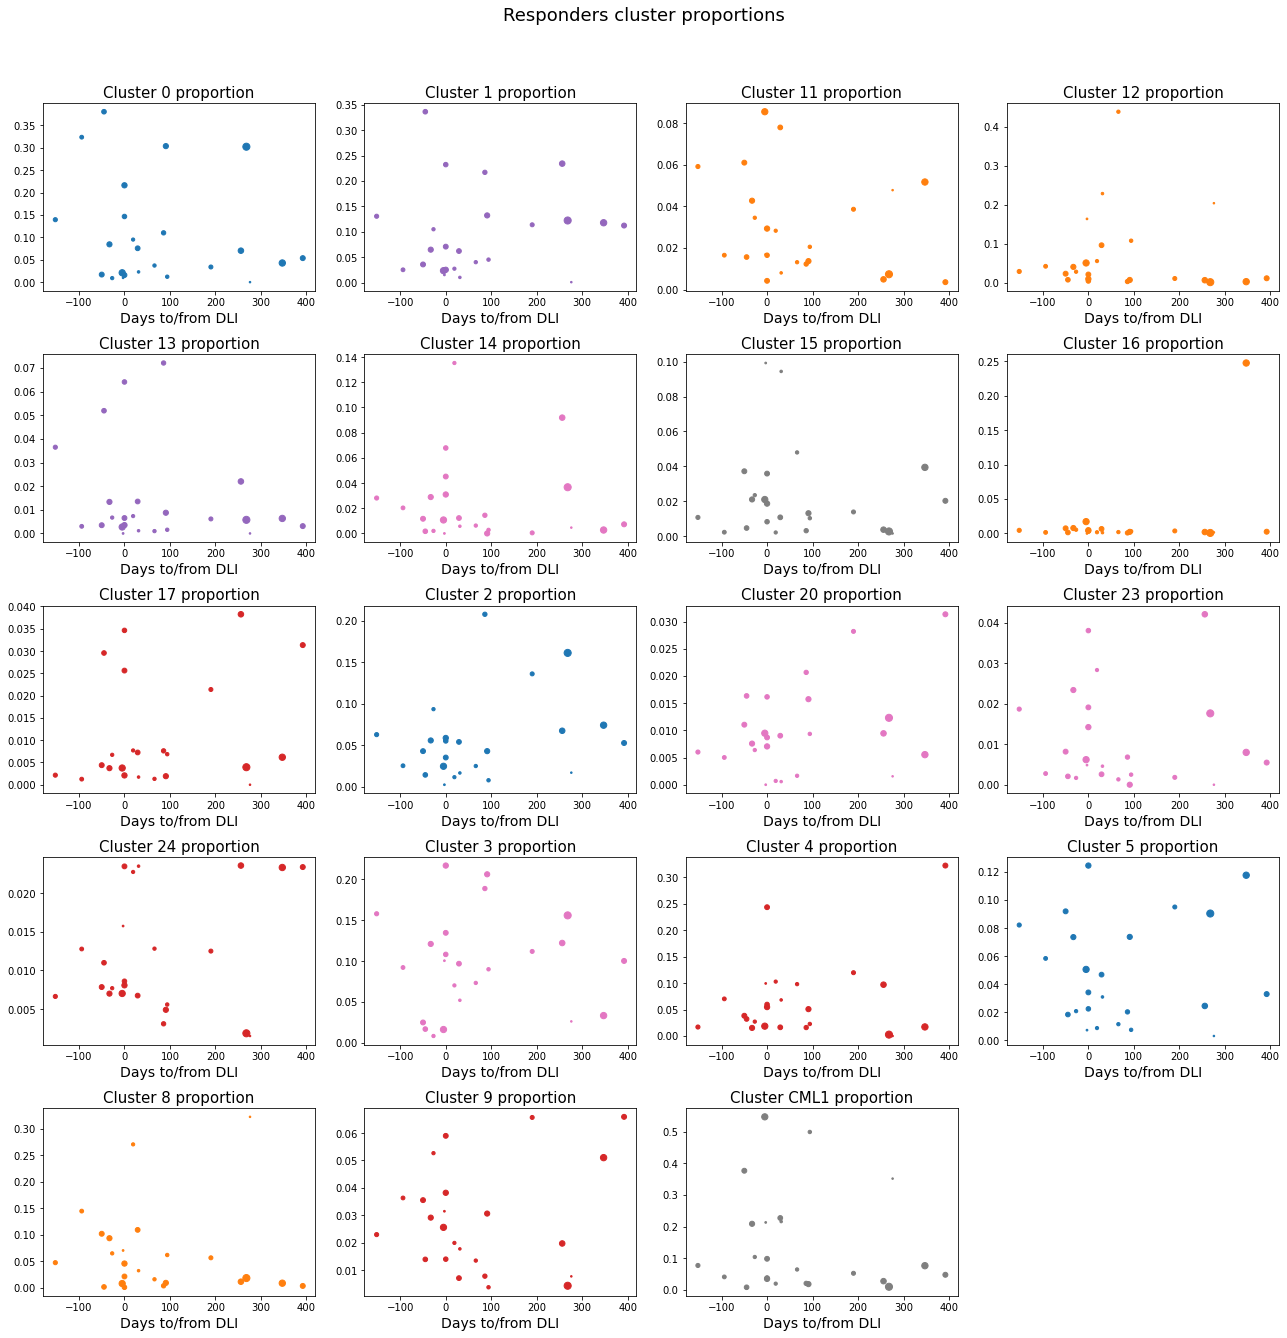

In [10]:
cells_per_sample = cells_df_responders['sample'].value_counts(normalize=True)[sample_cluster_proportions_df['sample']]

plt.figure(figsize=(18, 18))
for i, cluster in enumerate(clusters_of_interest):
    color = colors[list(clusters_of_interest.values())[i]]
    plt.subplot(5, 4, i+1)
    plt.scatter(sample_cluster_proportions_df['days_to_DLI'], 
                sample_cluster_proportions_df[cluster], 
                s=cells_per_sample*500, 
                color=color)
    plt.title(f'Cluster {cluster} proportion', fontsize=15)
    plt.xlabel('Days to/from DLI', fontsize=14)
plt.suptitle(f'Responders cluster proportions', y=1.03, fontsize=18)
plt.tight_layout()
plt.savefig('../../figures/CML/cell_type_proportions_R.eps', bbox_inches='tight')

In [11]:
cluster_means = sample_cluster_proportions_df[clusters_of_interest].mean()
cluster_std_devs = sample_cluster_proportions_df[clusters_of_interest].std()
sample_cluster_proportions_df.loc[:, clusters_of_interest] -= cluster_means
sample_cluster_proportions_df.loc[:, clusters_of_interest] /= cluster_std_devs
sample_cluster_proportions_df

/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_16212/858897236.py:1: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  cluster_means = sample_cluster_proportions_df[clusters_of_interest].mean()
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_16212/858897236.py:2: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  cluster_std_devs = sample_cluster_proportions_df[clusters_of_interest].std()
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_16212/858897236.py:3: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  sample_cluster_proportions_df.loc[:, clusters_of_interest] -= cluster_means
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_16212/858897236.py:3: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a 

,sample,days_to_DLI,0,1,11,12,13,14,15,16,...,2,20,23,24,3,4,5,8,9,CML1
11,B31_,-152.0,0.298818,0.405046,1.247823,-0.367304,1.084045,0.135003,-0.456473,-0.187637,...,0.134439,-0.488468,0.654191,-0.667342,1.014195,-0.658567,0.925332,-0.196075,-0.265895,-0.402455
10,B30_,-94.0,1.901913,-0.823023,-0.550643,-0.237262,-0.543680,-0.101683,-0.778502,-0.247872,...,-0.611807,-0.610925,-0.675500,0.137731,-0.077908,0.041284,0.284515,0.987213,0.429714,-0.631424
13,B39_,-50.0,-0.767531,-0.700475,1.326526,-0.423082,-0.520750,-0.363616,0.549449,-0.129396,...,-0.261375,0.129162,-0.223440,-0.508134,-1.195196,-0.378277,1.187937,0.467100,0.388498,1.493497
14,B5_,-45.0,2.396529,2.802184,-0.588340,-0.575747,1.834322,-0.664160,-0.687837,-0.250444,...,-0.831082,0.778561,-0.733443,-0.095866,-1.329889,-0.458748,-0.791711,-0.753145,-0.736177,-0.839039
8,B25_,-33.0,-0.180157,-0.361252,0.554511,-0.252396,-0.041212,0.158274,-0.064640,-0.120796,...,-0.005410,-0.297537,1.047716,-0.619849,0.400849,-0.680766,0.693511,0.365049,0.056375,0.431278
3,B1_,-27.0,-0.836083,0.106543,0.208622,-0.374067,-0.363570,-0.655248,0.028301,-0.170346,...,0.744976,-0.443476,-0.765613,-0.527402,-1.470385,-0.524061,-0.726825,0.017187,1.280307,-0.232757
6,B23_,-5.0,-0.732130,-0.842967,2.359573,-0.154018,-0.557643,-0.392503,-0.065986,0.066184,...,-0.624578,-0.063358,-0.388637,-0.617292,-1.338661,-0.637324,0.073669,-0.675260,-0.128560,2.572177
19,E3_,-3.0,-0.830618,-0.940640,-0.533111,0.951821,-0.689883,-0.716207,2.908937,-0.278025,...,-1.066358,-1.226113,-0.501069,0.527206,0.060013,0.424600,-1.091173,0.083738,0.177535,0.458822
17,E1_,0.0,-0.777107,-0.291812,-1.070687,-0.442926,-0.372784,0.651890,0.498694,-0.206398,...,-0.414387,-0.158692,0.689956,1.539548,0.626677,2.318904,-0.367375,-0.513219,1.609267,-0.268819
4,B21_,0.0,0.361000,1.589240,-0.551692,-0.605968,2.425743,1.338015,-0.550474,-0.202428,...,-0.016465,0.756884,2.273474,-0.409437,0.188230,-0.097753,-0.682913,-0.761133,-0.732215,-0.653153


In [12]:
X = sample_cluster_proportions_df['days_to_DLI'].values.reshape(-1, 1)
X

array([[-152.],
       [ -94.],
       [ -50.],
       [ -45.],
       [ -33.],
       [ -27.],
       [  -5.],
       [  -3.],
       [   0.],
       [   0.],
       [   0.],
       [  19.],
       [  29.],
       [  31.],
       [  66.],
       [  86.],
       [  91.],
       [  94.],
       [ 190.],
       [ 256.],
       [ 268.],
       [ 276.],
       [ 347.],
       [ 392.]])

In [13]:
Y = sample_cluster_proportions_df[clusters_of_interest].values
Y[:5]

/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_16212/2580917083.py:1: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  Y = sample_cluster_proportions_df[clusters_of_interest].values


array([[ 0.29881781,  0.40504586,  1.24782321, -0.36730386,  1.08404463,
         0.1350032 , -0.45647312, -0.18763668, -0.69409864,  0.13443873,
        -0.48846785,  0.65419131, -0.66734179,  1.01419549, -0.65856667,
         0.92533211, -0.19607481, -0.26589505, -0.40245541],
       [ 1.90191257, -0.82302348, -0.55064308, -0.23726239, -0.54367994,
        -0.10168253, -0.77850186, -0.24787199, -0.76797569, -0.61180698,
        -0.61092478, -0.67549997,  0.13773091, -0.07790752,  0.0412841 ,
         0.28451547,  0.98721338,  0.4297135 , -0.63142407],
       [-0.7675312 , -0.70047483,  1.32652579, -0.42308198, -0.52074958,
        -0.36361585,  0.54944903, -0.1293957 , -0.50884485, -0.26137469,
         0.1291615 , -0.22343965, -0.50813417, -1.19519584, -0.37827653,
         1.18793704,  0.46710019,  0.3884984 ,  1.49349657],
       [ 2.39652948,  2.80218362, -0.58834028, -0.57574654,  1.83432231,
        -0.66415961, -0.68783673, -0.25044392,  1.57385145, -0.83108236,
         0.778

Text(0.5, 1.02, 'Interaction prior variances for responders based on receptor-ligand expression')

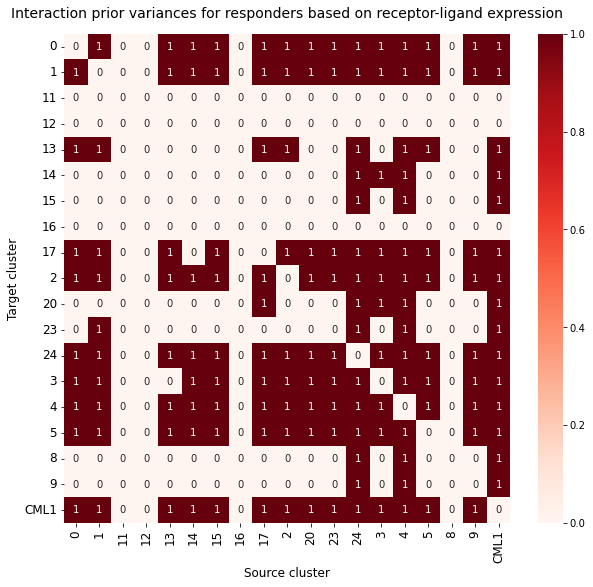

In [14]:
W_prior_variance = np.load('../../data/CML/responder_interaction_prior.npy')

plt.figure(figsize=(10, 9))
ax = sns.heatmap(W_prior_variance, cmap="Reds", annot=True)
ax.set_yticklabels(clusters_of_interest, fontsize=12, rotation=0)
ax.set_xticklabels(clusters_of_interest, fontsize=12, rotation=90)
plt.xlabel('Source cluster', fontsize=12)
plt.ylabel('Target cluster', fontsize=12)
plt.title('Interaction prior variances for responders based on receptor-ligand expression', 
          fontsize=14, y=1.02)

In [15]:
timepoints = torch.tensor(X)
proportions = torch.tensor(Y)
prior_matrix = torch.tensor(W_prior_variance)
n_timepoints, n_cell_types = proportions.shape

print('timepoints.shape:', timepoints.shape)
print('cell_types.shape:', proportions.shape)

timepoints.shape: torch.Size([24, 1])
cell_types.shape: torch.Size([24, 19])


In [16]:
def unscale(proportions, cluster_index): 
    return np.clip((proportions * 
                    cluster_std_devs.values[cluster_index] + 
                    cluster_means.values[cluster_index]), 
                   0, 1)

In [17]:
# mean of all intervals
lengthscale = np.mean(np.abs(X - X.T))
lengthscale

150.74305555555554

In [18]:
hyper_init_vals = {
    names.LENGTHSCALE_F: 150,
    names.LENGTHSCALE_W: 150,
    names.SIGMA_F: 1,
    names.VARIANCE_F: 1,
    names.SIGMA_W: 0.1,
    names.VARIANCE_W: 1,
    names.SIGMA_Y: 0.1,
}
print(hyper_init_vals)

{'lengthscale_f': 150, 'lengthscale_w': 150, 'sigma_f': 1, 'variance_f': 1, 'sigma_w': 0.1, 'variance_w': 1, 'sigma_y': 0.1}


In [19]:
model = DIISCO(lambda_matrix=prior_matrix, hypers_init_vals=hyper_init_vals, verbose=True, verbose_freq=100)

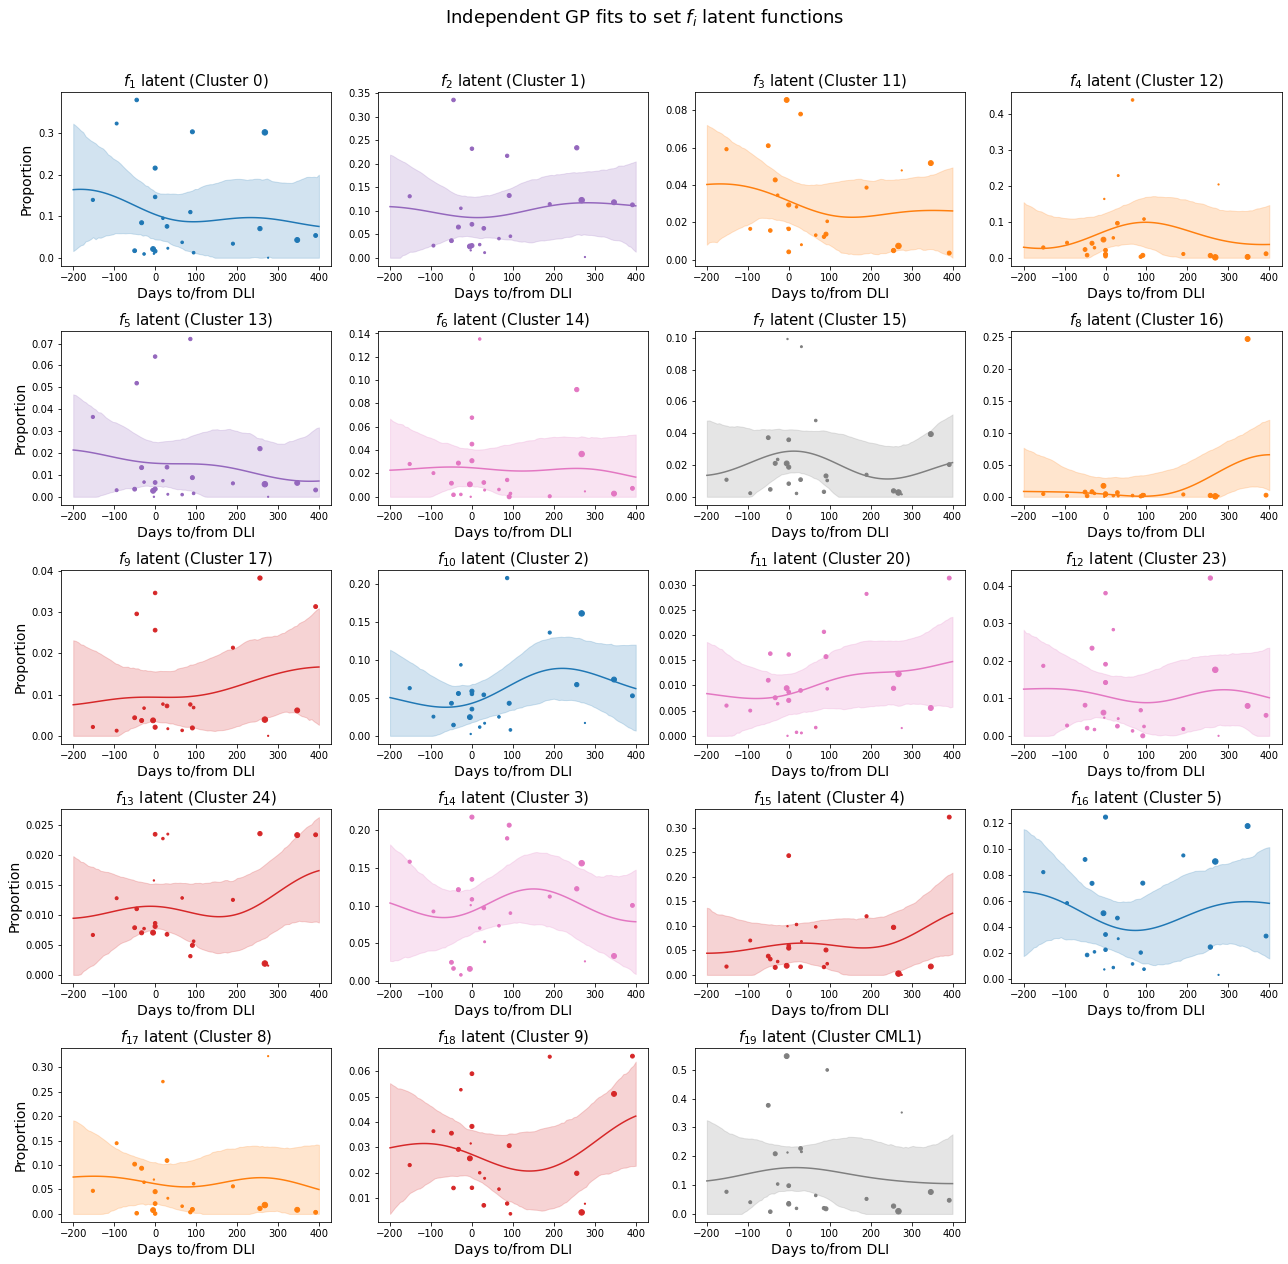

In [20]:
model.fit_and_set_f_prior_params(timepoints=timepoints, proportions=proportions, hypers=model.hypers_init_vals)
eval_timepoints = torch.linspace(-200, 400, 100).view(-1, 1)

n_samples = 1000
n_eval_timepoints = eval_timepoints.shape[0]
f_prior_np = model.sample_f_prior(eval_timepoints, n_samples=n_samples)

plt.figure(figsize=(18, 30))
for i, cluster in enumerate(clusters_of_interest):
    eval_timepoints_np = eval_timepoints.detach().numpy()
    f_prior_cell_type_np = f_prior_np[:, i, :].detach().numpy()
    mean = unscale(f_prior_cell_type_np.mean(axis=0), i)
    upper = unscale(np.percentile(f_prior_cell_type_np, 97.5, axis=0), i)
    lower = unscale(np.percentile(f_prior_cell_type_np, 2.5, axis=0), i)
    plt.subplot(9, 4, i+1)
    color = colors[list(clusters_of_interest.values())[i]]
#     color = 'tab:blue'
    plt.plot(eval_timepoints_np, mean, c=color)
    plt.scatter(timepoints, unscale(proportions[:, i].flatten().detach().numpy(), i), 
                c=color, s=cells_per_sample*300)
    plt.fill_between(eval_timepoints_np.flatten(), lower, upper, color=color, alpha=0.2)
    plt.title('$f_{%s}$ latent (Cluster %s)' % (i+1, cluster), fontsize=15)
    plt.xlabel('Days to/from DLI', fontsize=14)
    if i%4==0: plt.ylabel('Proportion', fontsize=14)
plt.subplots_adjust(hspace=0.4)
plt.suptitle('Independent GP fits to set $f_i$ latent functions', fontsize=18, y=1.01)
plt.tight_layout()

In [21]:
model.fit(timepoints, 
          proportions, 
          n_iter=100000, 
          lr=0.00001, 
          hypers_to_optim=[], 
          guide="MultivariateNormalFactorized")

[iteration 0001] loss: 1557023.7925
[iteration 0101] loss: 1039765.3687
[iteration 0201] loss: 979179.9309
[iteration 0301] loss: 940375.0416
[iteration 0401] loss: 915929.1290
[iteration 0501] loss: 892406.3496
[iteration 0601] loss: 880061.6115
[iteration 0701] loss: 865156.4575
[iteration 0801] loss: 848349.3362
[iteration 0901] loss: 838107.9444
[iteration 1001] loss: 824797.4651
[iteration 1101] loss: 817880.6704
[iteration 1201] loss: 807850.7538
[iteration 1301] loss: 800476.1081
[iteration 1401] loss: 793641.9602
[iteration 1501] loss: 782168.4440
[iteration 1601] loss: 776514.2742
[iteration 1701] loss: 769041.9314
[iteration 1801] loss: 761867.4918
[iteration 1901] loss: 758019.2210
[iteration 2001] loss: 749435.7264
[iteration 2101] loss: 741748.4373
[iteration 2201] loss: 736095.4875
[iteration 2301] loss: 735692.1359
[iteration 2401] loss: 729615.5938
[iteration 2501] loss: 723446.4348
[iteration 2601] loss: 718958.0356
[iteration 2701] loss: 715108.8142
[iteration 2801] l

[iteration 23101] loss: 386998.1472
[iteration 23201] loss: 390974.0379
[iteration 23301] loss: 387700.5853
[iteration 23401] loss: 387844.6124
[iteration 23501] loss: 386147.2668
[iteration 23601] loss: 383671.5921
[iteration 23701] loss: 383526.7742
[iteration 23801] loss: 382994.0833
[iteration 23901] loss: 383961.8077
[iteration 24001] loss: 383130.3745
[iteration 24101] loss: 383624.3550
[iteration 24201] loss: 379890.3068
[iteration 24301] loss: 376498.7634
[iteration 24401] loss: 384263.8593
[iteration 24501] loss: 380644.4970
[iteration 24601] loss: 378917.5674
[iteration 24701] loss: 379398.5907
[iteration 24801] loss: 378922.3886
[iteration 24901] loss: 379555.2271
[iteration 25001] loss: 385139.0346
[iteration 25101] loss: 374048.7258
[iteration 25201] loss: 373350.2947
[iteration 25301] loss: 373923.1618
[iteration 25401] loss: 376220.9905
[iteration 25501] loss: 373604.7803
[iteration 25601] loss: 372838.1509
[iteration 25701] loss: 378850.6380
[iteration 25801] loss: 3742

[iteration 45901] loss: 315360.6133
[iteration 46001] loss: 314553.4950
[iteration 46101] loss: 314790.8933
[iteration 46201] loss: 313445.0855
[iteration 46301] loss: 313872.9329
[iteration 46401] loss: 312742.4326
[iteration 46501] loss: 312640.6054
[iteration 46601] loss: 313407.3382
[iteration 46701] loss: 311772.3878
[iteration 46801] loss: 312374.2510
[iteration 46901] loss: 313361.9663
[iteration 47001] loss: 313317.5038
[iteration 47101] loss: 311456.9009
[iteration 47201] loss: 311676.0922
[iteration 47301] loss: 314954.2428
[iteration 47401] loss: 309828.0177
[iteration 47501] loss: 314307.8016
[iteration 47601] loss: 309014.5799
[iteration 47701] loss: 313052.9917
[iteration 47801] loss: 313595.7380
[iteration 47901] loss: 312016.7819
[iteration 48001] loss: 312463.7769
[iteration 48101] loss: 311289.6881
[iteration 48201] loss: 313740.3457
[iteration 48301] loss: 309647.0121
[iteration 48401] loss: 307984.8909
[iteration 48501] loss: 310710.7779
[iteration 48601] loss: 3138

[iteration 68701] loss: 281152.9443
[iteration 68801] loss: 281102.3158
[iteration 68901] loss: 283500.8627
[iteration 69001] loss: 280987.7508
[iteration 69101] loss: 284863.4973
[iteration 69201] loss: 283839.4804
[iteration 69301] loss: 287919.0506
[iteration 69401] loss: 281325.9242
[iteration 69501] loss: 283103.1430
[iteration 69601] loss: 280238.8409
[iteration 69701] loss: 280005.7726
[iteration 69801] loss: 285122.8014
[iteration 69901] loss: 279235.7992
[iteration 70001] loss: 282916.0237
[iteration 70101] loss: 284357.8353
[iteration 70201] loss: 291733.5776
[iteration 70301] loss: 281792.9370
[iteration 70401] loss: 281550.0422
[iteration 70501] loss: 280199.2003
[iteration 70601] loss: 281758.9808
[iteration 70701] loss: 278036.3865
[iteration 70801] loss: 278571.3228
[iteration 70901] loss: 283127.6699
[iteration 71001] loss: 284711.4615
[iteration 71101] loss: 283967.5707
[iteration 71201] loss: 277936.8437
[iteration 71301] loss: 288268.0333
[iteration 71401] loss: 2799

[iteration 91501] loss: 268008.9000
[iteration 91601] loss: 265197.7247
[iteration 91701] loss: 265755.8521
[iteration 91801] loss: 264696.5194
[iteration 91901] loss: 265205.3539
[iteration 92001] loss: 265000.5716
[iteration 92101] loss: 265155.3665
[iteration 92201] loss: 266794.9951
[iteration 92301] loss: 264429.5926
[iteration 92401] loss: 265358.5638
[iteration 92501] loss: 267172.6934
[iteration 92601] loss: 266628.2573
[iteration 92701] loss: 267744.0052
[iteration 92801] loss: 268197.4318
[iteration 92901] loss: 267393.9797
[iteration 93001] loss: 269769.5467
[iteration 93101] loss: 265820.0494
[iteration 93201] loss: 263976.6306
[iteration 93301] loss: 263754.1077
[iteration 93401] loss: 263501.1266
[iteration 93501] loss: 263056.9835
[iteration 93601] loss: 263706.2121
[iteration 93701] loss: 264829.3911
[iteration 93801] loss: 266111.8774
[iteration 93901] loss: 267376.9300
[iteration 94001] loss: 270700.8690
[iteration 94101] loss: 266164.5411
[iteration 94201] loss: 2669

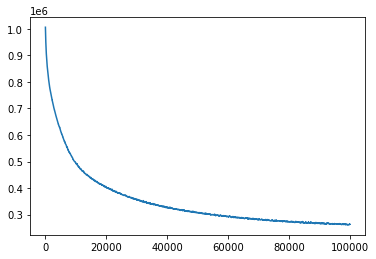

In [22]:
start = 100
loss_moving_avg = np.convolve(model.losses[start:], np.ones(100)/100, 'valid')
plt.plot(loss_moving_avg)

In [23]:
predict_timepoints = torch.linspace(timepoints.min(), timepoints.max(), 100).reshape(-1, 1)
means = model.get_means(predict_timepoints)

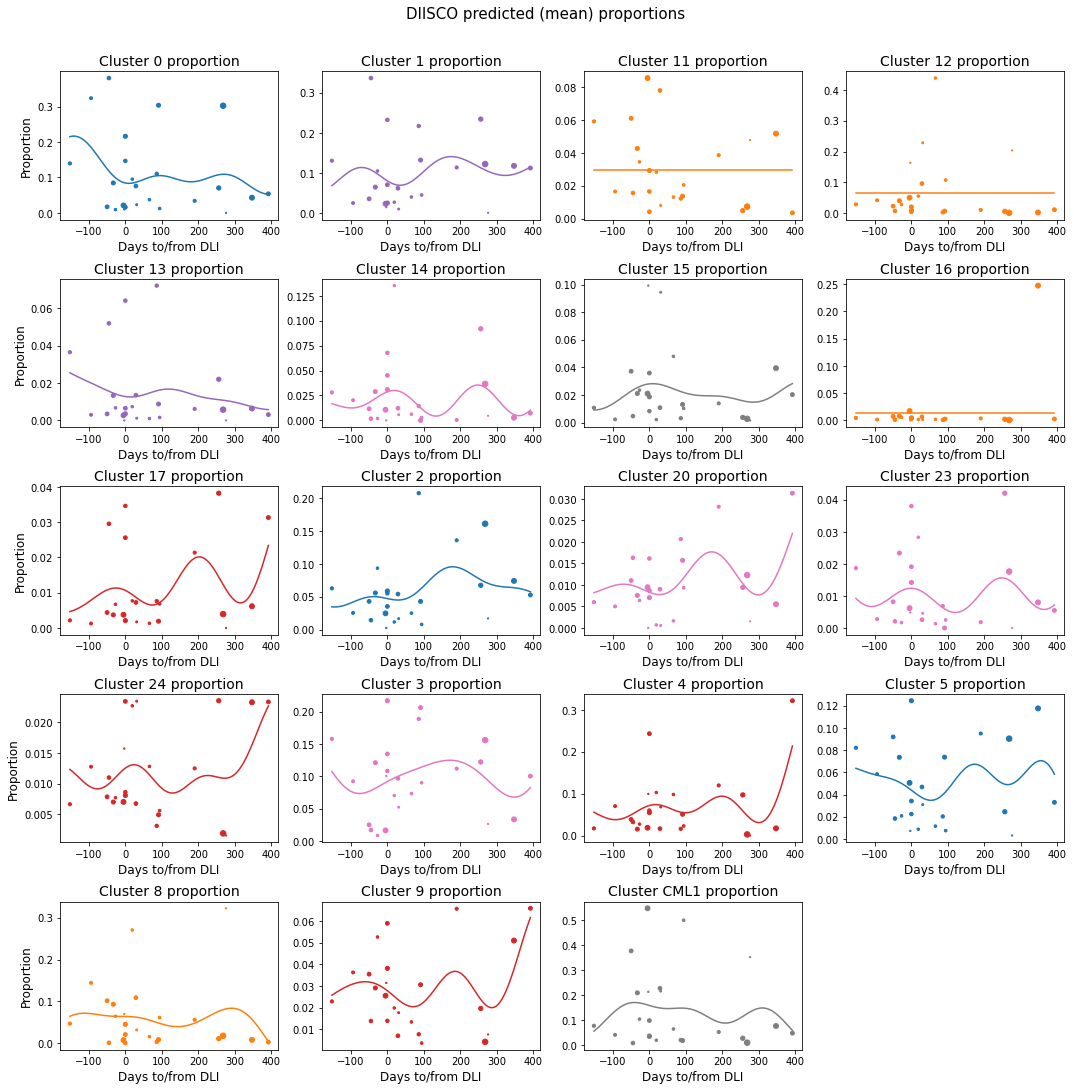

In [24]:
from mimic_alpha.mimic_alpha import colorAlpha_to_rgb
import matplotlib.colors as colors2

plt.figure(figsize=(18, 18))
for i, cluster in enumerate(clusters_of_interest):
    mean = unscale(means['Y'][:, i], i)
    x = predict_timepoints.squeeze().numpy()
    plt.subplot(5, 4, i+1)
    color = colors[list(clusters_of_interest.values())[i]]
#     color = 'tab:blue'
    plt.plot(x, mean, c=color)
    plt.scatter(timepoints, unscale(proportions[:, i], i), c=color, s=cells_per_sample*300)
    plt.title(f'Cluster {cluster} proportion', fontsize=14)
    plt.xlabel('Days to/from DLI', fontsize=12)
    if i%4==0: plt.ylabel('Proportion', fontsize=12)
    
plt.suptitle('DIISCO predicted (mean) proportions', fontsize=15, y=0.93)
plt.subplots_adjust(hspace=0.4)

In [25]:
predict_timepoints = torch.linspace(timepoints.min(), timepoints.max(), 100).reshape(-1, 1)
samples = model.sample(predict_timepoints, 
                 n_samples=10000, 
                 n_samples_per_latent=10,
                 include_emission_variance=False)

100%|██████████████████████████████████████| 10000/10000 [05:37<00:00, 29.67it/s]


In [26]:
W_samples_predict = samples['W']
f_samples_predict = samples['F']
y_samples_predict = samples['Y']

In [27]:
y_preds = y_samples_predict.mean(axis=0).numpy()

np.save('../../data/CML/X_R.npy', predict_timepoints.numpy())
np.save('../../data/CML/y_preds_R.npy', y_preds)
np.save('../../data/CML/W_samples_predict_R.npy', W_samples_predict)
np.save('../../data/CML/y_samples_predict_R.npy', y_samples_predict)

In [19]:
predict_timepoints = np.load('../../data/CML/X_R.npy')
y_preds = np.load('../../data/CML/y_preds_R.npy')
W_samples_predict = np.load('../../data/CML/W_samples_predict_R.npy')
y_samples_predict = np.load('../../data/CML/y_samples_predict_R.npy')

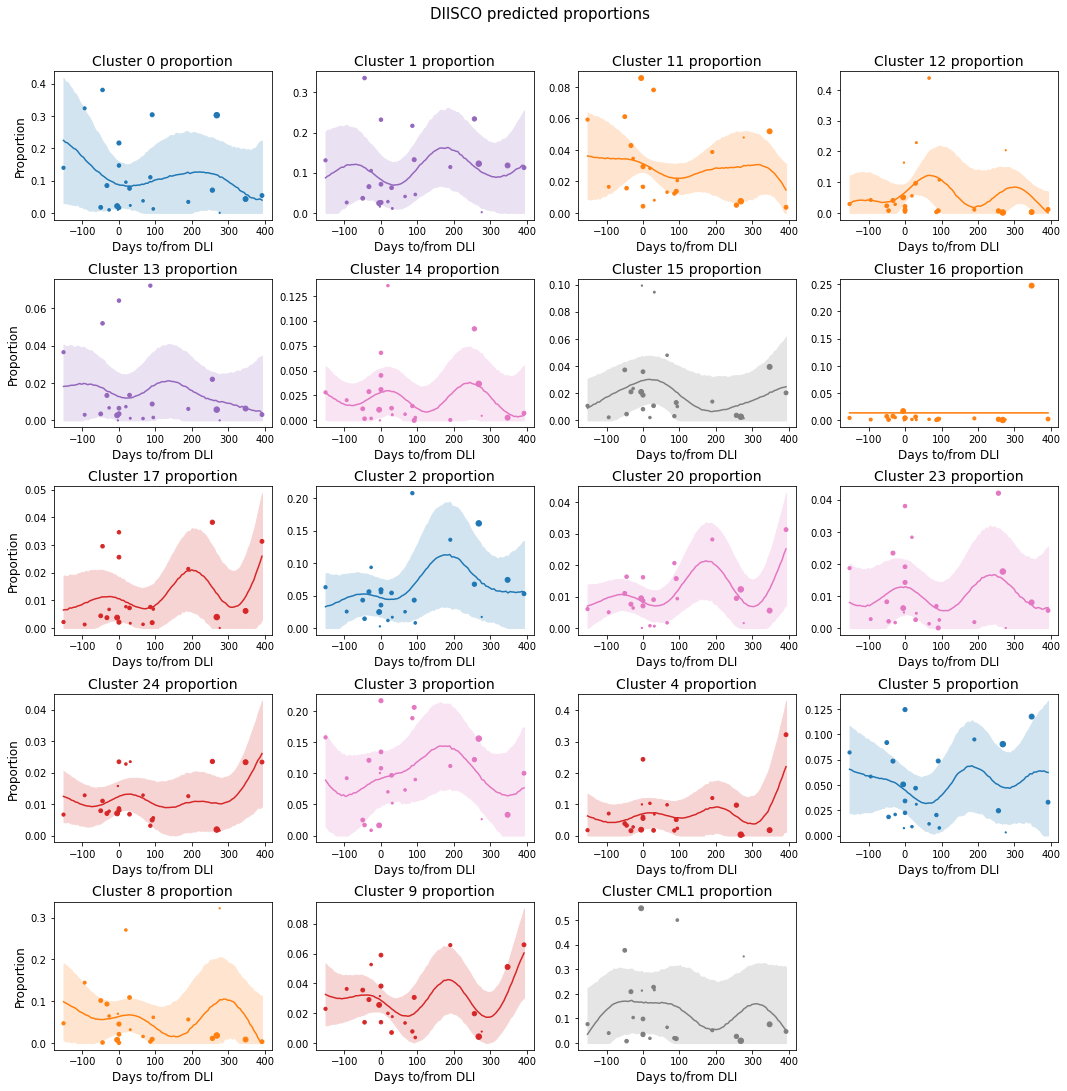

In [20]:
from mimic_alpha.mimic_alpha import colorAlpha_to_rgb
import matplotlib.colors as colors2

plt.figure(figsize=(18, 18))
for i, cluster in enumerate(clusters_of_interest):
    cell_type_samples = y_samples_predict[:, :, i]
    mean = unscale(cell_type_samples.mean(axis=0), i)
    x = predict_timepoints.squeeze()
    percentile_75 = unscale(np.percentile(cell_type_samples, 84, axis=0), i)
    percentile_25 = unscale(np.percentile(cell_type_samples, 16, axis=0), i)
    plt.subplot(5, 4, i+1)
    color = colors[list(clusters_of_interest.values())[i]]
    plt.plot(x, mean, c=color)
    color_with_alpha = list(colors2.to_rgb(color)) + [0.2]
    color_without_alpha = colorAlpha_to_rgb([color_with_alpha], 0.2)
    plt.fill_between(x, percentile_25, percentile_75, color=color_without_alpha)
    plt.scatter(timepoints, unscale(proportions[:, i], i), c=color, s=cells_per_sample*300)
    plt.title(f'Cluster {cluster} proportion', fontsize=14)
    plt.xlabel('Days to/from DLI', fontsize=12)
    if i%4==0: plt.ylabel('Proportion', fontsize=12)
    
plt.suptitle('DIISCO predicted proportions', fontsize=15, y=0.93)
plt.subplots_adjust(hspace=0.4)
plt.savefig('../../figures/CML/diisco_predictions_R.eps')

Text(0.5, 1.0, '$\\hat{W}_{avg}$ (400 days post-DLI)')

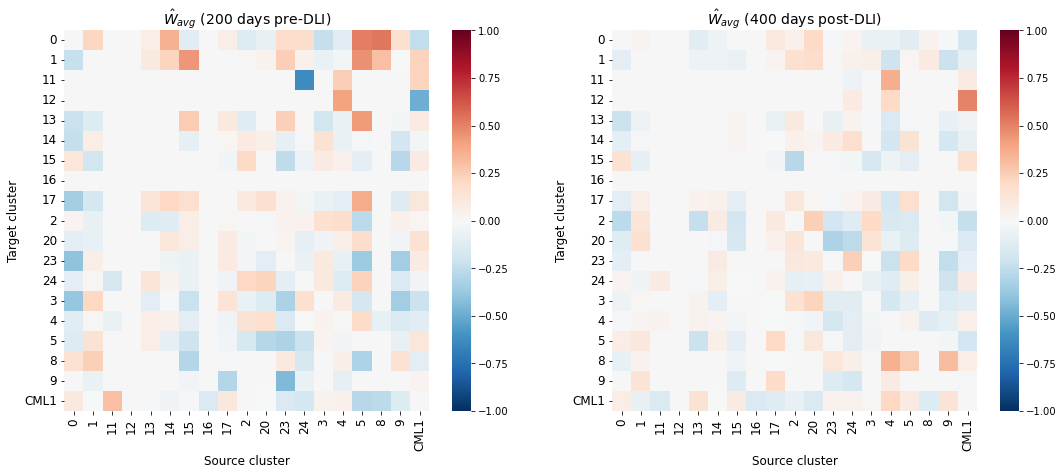

In [21]:
annot = False
vmin = -1
vmax = 1

X_200_days_pre_dli_index = np.where(predict_timepoints > -200)[0][0]
X_post_dli_index = np.where(predict_timepoints > 0)[0][0]
X_400_days_post_dli_index = np.where(predict_timepoints > 390)[0][0]
X_post_dli_index

W = W_samples_predict.mean(axis=0)
W_pre_dli = W[X_200_days_pre_dli_index:X_post_dli_index]
W_post_dli = W[X_post_dli_index:X_400_days_post_dli_index]
W_pre_dli_avg_over_time = np.mean(W_pre_dli, axis=0)
W_post_dli_avg_over_time = np.mean(W_post_dli, axis=0)

plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
ax = sns.heatmap(W_pre_dli_avg_over_time, cmap="RdBu_r", annot=annot, 
                 fmt='.2f', vmin=vmin, vmax=vmax, center=0)
ax.set_yticklabels(clusters_of_interest, fontsize=12)
ax.set_xticklabels(clusters_of_interest, fontsize=12)
plt.xlabel('Source cluster', fontsize=12)
plt.ylabel('Target cluster', fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.title('$\hat{W}_{avg}$ (200 days pre-DLI)', fontsize=14)

plt.subplot(1, 2, 2)
ax = sns.heatmap(W_post_dli_avg_over_time, cmap="RdBu_r", annot=annot, 
                 fmt='.2f', vmin=vmin, vmax=vmax, center=0)
ax.set_yticklabels(clusters_of_interest, fontsize=12)
ax.set_xticklabels(clusters_of_interest, fontsize=12)
plt.xlabel('Source cluster', fontsize=12)
plt.ylabel('Target cluster', fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.title('$\hat{W}_{avg}$ (400 days post-DLI)', fontsize=14)
# plt.savefig('../../figures/AML/run_3/W_avg_pre_post_DLI_R.eps')

In [22]:
y_samples_predict_unscaled = [unscale(y_samples_predict[:, :, i], i) 
                              for i in range(len(clusters_of_interest))]
y_samples_predict_unscaled = np.dstack(y_samples_predict_unscaled)
y_samples_predict_unscaled.shape

(10000, 100, 19)

In [23]:
y_mu = y_samples_predict_unscaled.mean(axis=0).mean(axis=0)
y_sigma = y_samples_predict_unscaled.std(axis=0).mean(axis=0)

y_mu_over_sigma = np.array(y_mu) / np.array(y_sigma)

(0.0, 2.0)

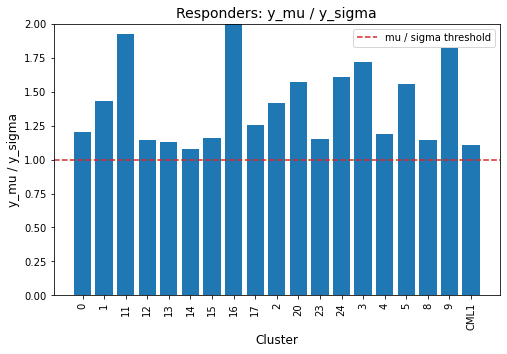

In [24]:
plt.figure(figsize=(8, 5))
mu_sigma_threshold = 1.0
plt.bar(range(len(y_mu_over_sigma)), y_mu_over_sigma)
plt.xticks(range(len(y_mu_over_sigma)), clusters_of_interest, rotation=90)
plt.axhline(mu_sigma_threshold, c='tab:red', linestyle='--', label='mu / sigma threshold')
plt.legend(loc='upper right')
plt.title("Responders: y_mu / y_sigma", fontsize=14)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("y_mu / y_sigma", fontsize=12)
plt.ylim([0, 2])

In [25]:
mean_abs_W_threshold = 0.23
max_abs_W_threshold = 1
mu_sigma_threshold = 1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


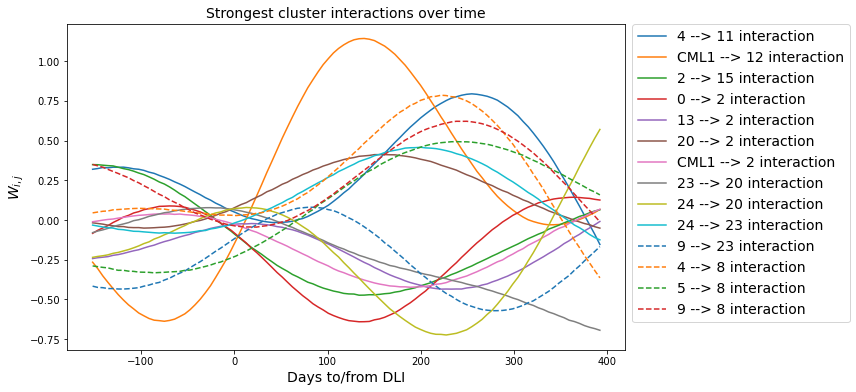

In [26]:
plt.figure(figsize=(10, 6))
linestyles = ['-', '--', ":"]
lines = 0
for i, cluster_i in enumerate(clusters_of_interest):
    for j, cluster_j in enumerate(clusters_of_interest):
        # a sustained strong interaction over the entire post-DLI time period
        sustained = np.abs(W_post_dli_avg_over_time[i, j]) > mean_abs_W_threshold
        # a transient strong interaction during the post-DLI time period
        transient = (np.abs(W_post_dli[:, i, j]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[i] > mu_sigma_threshold and
                     y_mu_over_sigma[j] > mu_sigma_threshold)
        show_line = (sustained or transient) and confident
        if show_line and i!= j:
            plt.plot(predict_timepoints.squeeze(),
                     W[:, i, j],
                     linestyle=linestyles[lines//10],
                     label='%s --> %s interaction' % (cluster_j, cluster_i))
            lines += 1
plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left', fontsize=14)
plt.title('Strongest cluster interactions over time', fontsize=14)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('Days to/from DLI', fontsize=14)
plt.savefig('../../figures/CML/W_over_time_R_top_interactions.eps', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


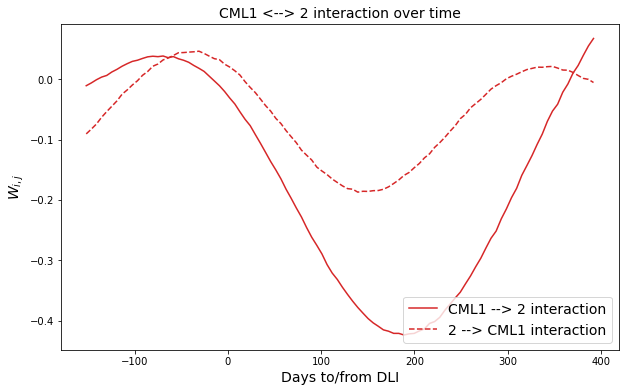

In [27]:
i = 9
j = 18
cluster_i = list(clusters_of_interest.keys())[i]
cluster_j = list(clusters_of_interest.keys())[j]

plt.figure(figsize=(10, 6))
plt.plot(predict_timepoints.squeeze(),
         W[:, i, j],
         linestyle='-',
         color='tab:red',
         label='%s --> %s interaction' % (cluster_j, cluster_i))
plt.plot(predict_timepoints.squeeze(),
         W[:, j, i],
         linestyle='--',
         color='tab:red',
         label='%s --> %s interaction' % (cluster_i, cluster_j))

plt.legend(loc='lower right', fontsize=14)
plt.title('CML1 <--> 2 interaction over time', fontsize=14)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('Days to/from DLI', fontsize=14)
plt.savefig('../../figures/CML/W_CML1_and_2_over_time_R.eps', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


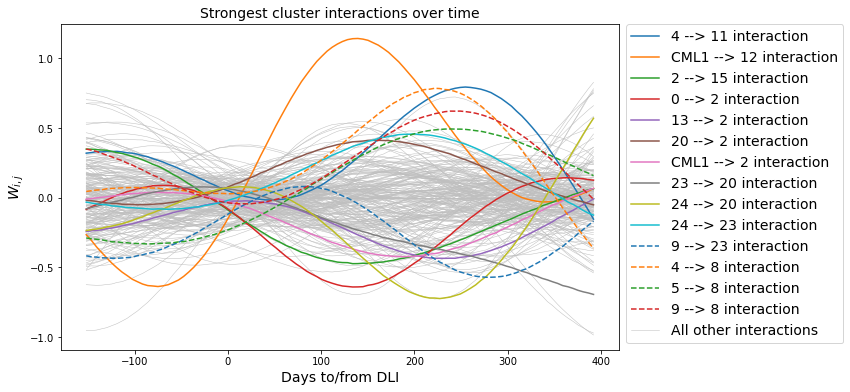

In [28]:
plt.figure(figsize=(10, 6))
linestyles = ['-', '--', ":"]
lines = 0
for i, cluster_i in enumerate(clusters_of_interest):
    for j, cluster_j in enumerate(clusters_of_interest):
        # a sustained strong interaction over the entire post-DLI time period
        sustained = np.abs(W_post_dli_avg_over_time[i, j]) > mean_abs_W_threshold
        # a transient strong interaction during the post-DLI time period
        transient = (np.abs(W_post_dli[:, i, j]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[i] > mu_sigma_threshold and
                     y_mu_over_sigma[j] > mu_sigma_threshold)
        show_line = (sustained or transient) and confident
        if show_line and i!= j:
            plt.plot(predict_timepoints.squeeze(), 
                     W[:, i, j],
                     linestyles[lines//10],
                     label='%s --> %s interaction' % (cluster_j, cluster_i))
            lines += 1
            
once = False
color = 'tab:gray'
color_with_alpha = list(colors2.to_rgb(color)) + [0.5]
color_without_alpha = colorAlpha_to_rgb([color_with_alpha], 0.5)
for i, cluster_i in enumerate(clusters_of_interest):
    for j, cluster_j in enumerate(clusters_of_interest):
        # a sustained strong interaction over the entire post-DLI time period
        sustained = np.abs(W_post_dli_avg_over_time[i, j]) > mean_abs_W_threshold
        # a transient strong interaction during the post-DLI time period
        transient = (np.abs(W_post_dli[:, i, j]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[i] > mu_sigma_threshold and
                     y_mu_over_sigma[j] > mu_sigma_threshold)
        show_line = (sustained or transient) and confident
        if not show_line and i != j:
            plt.plot(predict_timepoints.squeeze(), 
                     W[:, i, j],
                     color=color_without_alpha[0],
                     linewidth=0.5, zorder=-100,
                     label='All other interactions' if not once else '')
            once = True

plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left', fontsize=14)
plt.title('Strongest cluster interactions over time', fontsize=14)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('Days to/from DLI', fontsize=14)
plt.savefig('../../figures/CML/W_over_time_R_all_interactions.eps', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


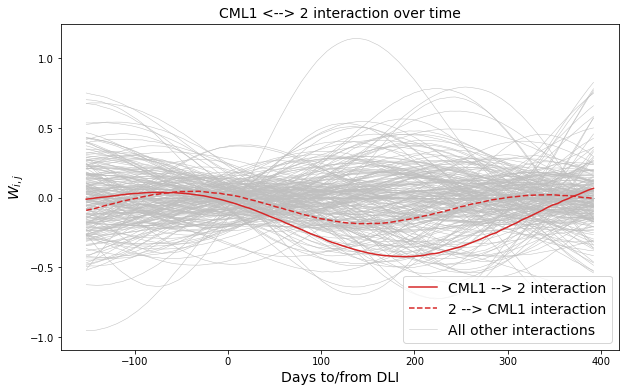

In [29]:
i = 9
j = 18
cluster_i = list(clusters_of_interest.keys())[i]
cluster_j = list(clusters_of_interest.keys())[j]

plt.figure(figsize=(10, 6))
plt.plot(predict_timepoints.squeeze(),
         W[:, i, j],
         linestyle='-',
         color='tab:red',
         label='%s --> %s interaction' % (cluster_j, cluster_i))
plt.plot(predict_timepoints.squeeze(),
         W[:, j, i],
         linestyle='--',
         color='tab:red',
         label='%s --> %s interaction' % (cluster_i, cluster_j))
            
once = False
color = 'tab:gray'
color_with_alpha = list(colors2.to_rgb(color)) + [0.5]
color_without_alpha = colorAlpha_to_rgb([color_with_alpha], 0.5)
for i, cluster_i in enumerate(clusters_of_interest):
    for j, cluster_j in enumerate(clusters_of_interest):
        # a sustained strong interaction over the entire post-DLI time period
        sustained = np.abs(W_post_dli_avg_over_time[i, j]) > mean_abs_W_threshold
        # a transient strong interaction during the post-DLI time period
        transient = (np.abs(W_post_dli[:, i, j]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[i] > mu_sigma_threshold and
                     y_mu_over_sigma[j] > mu_sigma_threshold)
        show_line = (sustained or transient) and confident
        if i != j:
            plt.plot(predict_timepoints.squeeze(), 
                     W[:, i, j],
                     color=color_without_alpha[0],
                     linewidth=0.5, zorder=-100,
                     label='All other interactions' if not once else '')
            once = True

plt.legend(loc='lower right', fontsize=14)
plt.title('CML1 <--> 2 interaction over time', fontsize=14)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('Days to/from DLI', fontsize=14)
plt.savefig('../../figures/CML/W_CML1_and_2_over_time_R_all_interactions.eps', bbox_inches='tight')

In [30]:
import py4cytoscape as p4c
p4c.cytoscape_ping()
p4c.cytoscape_version_info()

/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


You are connected to Cytoscape!


{'apiVersion': 'v1',
 'cytoscapeVersion': '3.9.1',
 'automationAPIVersion': '1.6.0',
 'py4cytoscapeVersion': '1.5.0'}

In [31]:
W_pre_dli_avg_edge_list = []

for row, target_cluster in enumerate(clusters_of_interest.keys()):
    for col, source_cluster in enumerate(clusters_of_interest.keys()):
        sustained = np.abs(W_post_dli_avg_over_time[row, col]) > mean_abs_W_threshold
        transient = (np.abs(W_post_dli[:, row, col]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[row] > mu_sigma_threshold and
                     y_mu_over_sigma[col] > mu_sigma_threshold)
        show_edge = (sustained or transient) and confident
        W_pre_dli_avg_edge_list.append({
            'Source cluster': source_cluster,
            'Target cluster': target_cluster,
            'Interaction weight': W_pre_dli_avg_over_time[row, col],
            'abs(Interaction weight)': np.abs(W_pre_dli_avg_over_time[row, col]) * show_edge,
            'sign(Interaction weight)': np.sign(W_pre_dli_avg_over_time[row, col])
        })

W_pre_dli_avg_edge_list_df = pd.DataFrame(W_pre_dli_avg_edge_list)

W_avg_edge_list_df = W_pre_dli_avg_edge_list_df
W_avg_edge_list_df.columns = ['source', 'target', 'Interaction weight', 
                              'abs(Interaction weight)', 'sign(Interaction weight)']
W_avg_edge_list_df[['source', 'target']] = W_avg_edge_list_df[['source', 'target']].astype(str)
W_avg_edge_list_df = W_avg_edge_list_df[W_avg_edge_list_df['source'] != W_avg_edge_list_df['target']]
W_avg_edge_list_df.head()

,source,target,Interaction weight,abs(Interaction weight),sign(Interaction weight)
1,1,0,0.216619,0.0,1.0
2,11,0,0.000000,0.0,0.0
3,12,0,0.000000,0.0,0.0
4,13,0,0.076418,0.0,1.0
5,14,0,0.354636,0.0,1.0


In [32]:
# Display 2 --> CML1 edge
edge_2_to_CML1 = ((W_avg_edge_list_df['source'] == '2') & 
                  (W_avg_edge_list_df['target'] == 'CML1'))
W_avg_edge_list_df.loc[edge_2_to_CML1, 'abs(Interaction weight)'] = \
    np.abs(W_avg_edge_list_df.loc[edge_2_to_CML1, 'Interaction weight'])

W_avg_edge_list_df.loc[edge_2_to_CML1]

,source,target,Interaction weight,abs(Interaction weight),sign(Interaction weight)
351,2,CML1,0.002389,0.002389,1.0


In [33]:
# y_preds = y_samples_predict.mean(axis=0).numpy()
y_preds_pre_dli = y_preds[X_200_days_pre_dli_index:X_post_dli_index]
y_preds_avg_pre_dli = y_preds_pre_dli.mean(axis=0)
y_preds_avg_pre_dli = [unscale(y, i) for i, y in enumerate(y_preds_avg_pre_dli)]
y_preds_avg_pre_dli_df = pd.DataFrame(y_preds_avg_pre_dli,
                                      index=clusters_of_interest, 
                                      columns=['Inferred cluster proportion'])

y_preds_avg_df = y_preds_avg_pre_dli_df.reset_index()
y_preds_avg_df.columns = ['id', 'Inferred cluster proportion']
y_preds_avg_df['id'] = y_preds_avg_df['id'].astype(str)
y_preds_avg_df

,id,Inferred cluster proportion
0,0,0.151637
1,1,0.106940
2,11,0.034303
3,12,0.040659
4,13,0.017714
5,14,0.020318
6,15,0.019780
7,16,0.013858
8,17,0.009415
9,2,0.045746


In [34]:
# Reduce clutter by removing nodes without edges
not_connected_cluster_ids = []
for cluster in clusters_of_interest:
    sum_abs_interaction_weights = (
        W_avg_edge_list_df.loc[(W_avg_edge_list_df['source'] == str(cluster)) | 
                               (W_avg_edge_list_df['target'] == str(cluster)), 
                               'abs(Interaction weight)'].sum()
    )
    if sum_abs_interaction_weights == 0: 
        not_connected_cluster_ids.append(str(cluster))

        
# Remove nodes with less than 1% cluster proportion
clusters_with_low_prop = y_preds_avg_df.loc[y_preds_avg_df['Inferred cluster proportion'] < 0, 'id']

clusters_to_remove = not_connected_cluster_ids + list(clusters_with_low_prop)
W_avg_edge_list_df = W_avg_edge_list_df[~(W_avg_edge_list_df['source'].isin(clusters_to_remove)) & 
                                        ~(W_avg_edge_list_df['target'].isin(clusters_to_remove))]
y_preds_avg_df = y_preds_avg_df[~(y_preds_avg_df['id'].isin(clusters_to_remove))]

In [35]:
# No MC5_leuk cells present in responders, so setting proportion to 0
# to align network diagram with NR
sample_cluster_proportions_all_df['MC5_leuk'] = 0

In [36]:
# Add clusters from NR interaction network diagram
clusters_to_add = {'30': 'Myeloid',
                   'CML2': 'CML',
                   '3': 'B cell',
                   '37': 'Myeloid'}

proportions_pre_dli_df = sample_cluster_proportions_all_df[sample_cluster_proportions_all_df['days_to_DLI'] < 0]
proportions_pre_dli_df = proportions_pre_dli_df[clusters_to_add].mean().reset_index()
proportions_pre_dli_df.columns = ['id', 'Inferred cluster proportion']
y_preds_avg_df = pd.concat([y_preds_avg_df, proportions_pre_dli_df])
y_preds_avg_df = y_preds_avg_df.sort_values('id').reset_index(drop=True)

# Add a fake 0 interactions so that cluster shows up in network diagram
for cluster in clusters_to_add:
    W_avg_edge_list_df = W_avg_edge_list_df.append({
        'source': cluster, 
        'target': '0', 
        'Interaction weight': 0,
        'abs(Interaction weight)': 0,
        'sign(Interaction weight)': 1
    }, ignore_index=True)
    W_avg_edge_list_df = W_avg_edge_list_df.append({
        'source': cluster, 
        'target': '5', 
        'Interaction weight': 0,
        'abs(Interaction weight)': 0,
        'sign(Interaction weight)': 1
    }, ignore_index=True)

/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_16212/2664477457.py:8: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  proportions_pre_dli_df = proportions_pre_dli_df[clusters_to_add].mean().reset_index()
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_16212/2664477457.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_avg_edge_list_df = W_avg_edge_list_df.append({
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_16212/2664477457.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_avg_edge_list_df = W_avg_edge_list_df.append({
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_16212/2664477457.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

In [37]:
colors_hex = {
    'T cell': '#CBE0EE',
    'B cell': '#F9E0F2',
    'Myeloid': '#F8CECD',
    'AML': '#E1E1E1',
    'CML': '#E1E1E1',
    'HSC': '#F8EBCB',
    'NK cell': '#E7DDF0',
    'Erythroid': '#FDE5CF'
}

clusters_to_colors_hex = [
    colors_hex[clusters_of_interest[cluster]] if cluster in clusters_of_interest
    else colors_hex[clusters_to_add[cluster]]
    for cluster in y_preds_avg_df['id']
]

# clusters_to_colors_hex = ['#CBE0EE' for cluster in y_preds_avg_df['id']]

Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
This file already exists. A Cytoscape popup will be generated to confirm overwrite.
This file already exists. A Cytoscape popup will be generated to confirm overwrite.


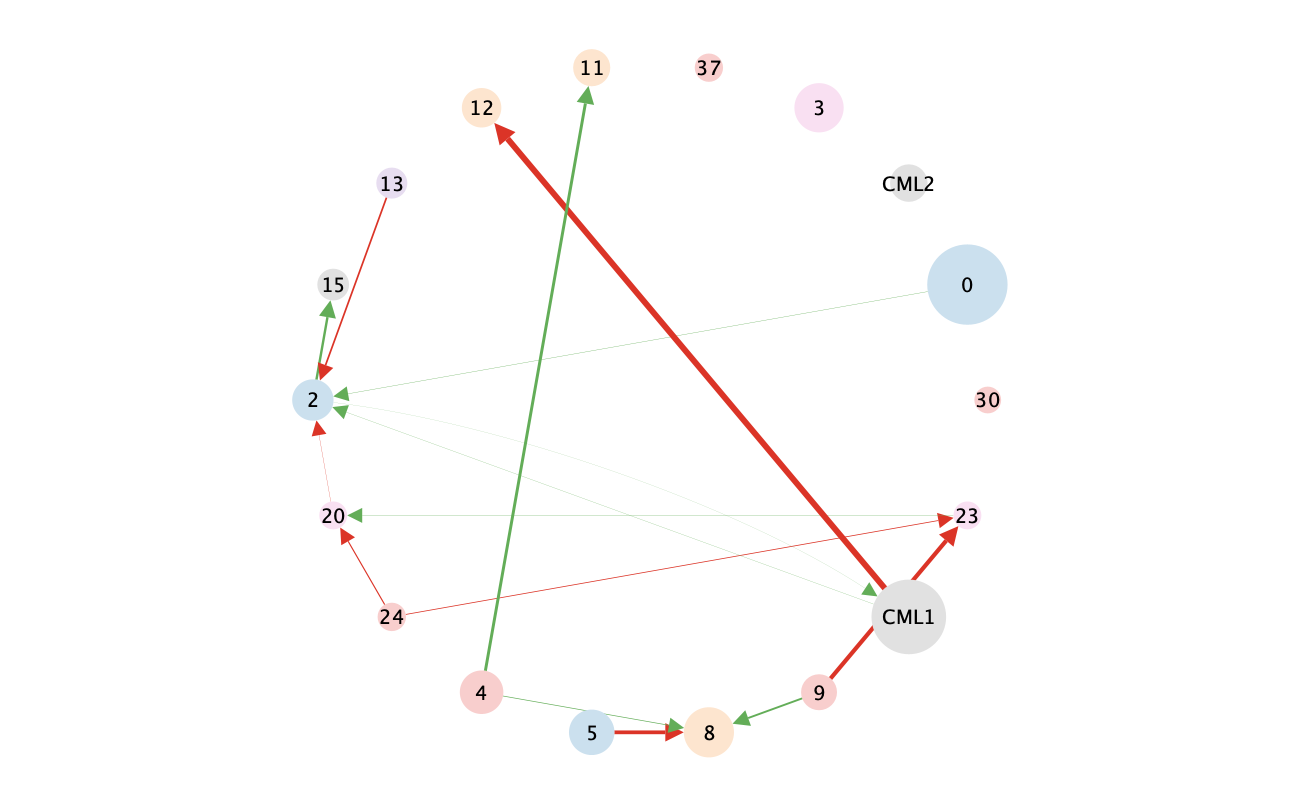

In [38]:
p4c.create_network_from_data_frames(nodes=y_preds_avg_df, 
                                    edges=W_avg_edge_list_df, 
                                    title="AML Responders Pre DLI", 
                                    collection="AML Responders Pre DLI")

# Default styles
p4c.layout_network('circular')
# p4c.layout_copycat(source_network='AML Responders Pre DLI', 
#                    target_network='AML Responders Pre DLI')
p4c.set_node_shape_default('ELLIPSE')
p4c.set_node_width_default(20)
p4c.set_node_height_default(20)
p4c.set_node_font_size_default(8)
p4c.set_edge_target_arrow_shape_default('DELTA_SHORT_1')

# Map style properties to node/edge attributes
p4c.set_node_color_mapping(table_column='shared name', 
                           table_column_values=list(y_preds_avg_df['id']), 
                           colors=clusters_to_colors_hex, 
                           mapping_type='d')
p4c.set_node_size_mapping(table_column='SUID',
                          table_column_values=list(p4c.get_table_columns()['SUID']),
                          sizes=list(p4c.get_table_columns()['Inferred cluster proportion'] * 150 + 10))
p4c.set_edge_color_mapping(table_column='sign(Interaction weight)',
                           table_column_values=[-1.0, 1.0],
                           colors=['#DB3427', '#63AD58'])
p4c.set_edge_target_arrow_color_mapping(table_column='sign(Interaction weight)',
                                        table_column_values=[-1.0, 1.0],
                                        colors=['#DB3427', '#63AD58'])
p4c.set_edge_line_width_mapping(table_column='abs(Interaction weight)', 
                                table_column_values=[W_avg_edge_list_df['abs(Interaction weight)'].min(), 
                                                     W_avg_edge_list_df['abs(Interaction weight)'].max()],
                                widths=[W_avg_edge_list_df['abs(Interaction weight)'].min() * 5, 
                                        W_avg_edge_list_df['abs(Interaction weight)'].max() * 5], 
                                mapping_type='c')
edges_to_hide = [f'{row.source} (interacts with) {row.target}' 
                 for i, row in W_avg_edge_list_df.iterrows()
                 if row['abs(Interaction weight)'] == 0]
p4c.hide_edges(edges_to_hide)

p4c.set_network_center_bypass(0, 0)
p4c.set_network_zoom_bypass(1.5)
p4c.export_image(f'../../figures/CML/interaction_network_R_pre_avg.svg', type='SVG')
p4c.export_image(f'../../figures/CML/interaction_network_R_pre_avg.png', type='PNG')
p4c.notebook_export_show_image()

In [39]:
W_post_dli_avg_edge_list = []

for row, target_cluster in enumerate(clusters_of_interest.keys()):
    for col, source_cluster in enumerate(clusters_of_interest.keys()):
        sustained = np.abs(W_post_dli_avg_over_time[row, col]) > mean_abs_W_threshold
        transient = (np.abs(W_post_dli[:, row, col]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[row] > mu_sigma_threshold and
                     y_mu_over_sigma[col] > mu_sigma_threshold)
        show_edge = (sustained or transient) and confident
        W_post_dli_avg_edge_list.append({
            'Source cluster': source_cluster,
            'Target cluster': target_cluster,
            'Interaction weight': W_post_dli_avg_over_time[row, col],
            'abs(Interaction weight)': np.abs(W_post_dli_avg_over_time[row, col]) * show_edge,
            'sign(Interaction weight)': np.sign(W_post_dli_avg_over_time[row, col])
        })
        
W_post_dli_avg_edge_list_df = pd.DataFrame(W_post_dli_avg_edge_list)

W_avg_edge_list_df = W_post_dli_avg_edge_list_df
W_avg_edge_list_df.columns = ['source', 'target', 'Interaction weight', 
                              'abs(Interaction weight)', 'sign(Interaction weight)']
W_avg_edge_list_df[['source', 'target']] = W_avg_edge_list_df[['source', 'target']].astype(str)
W_avg_edge_list_df = W_avg_edge_list_df[W_avg_edge_list_df['source'] != W_avg_edge_list_df['target']]
W_avg_edge_list_df.head()

,source,target,Interaction weight,abs(Interaction weight),sign(Interaction weight)
1,1,0,0.027111,0.0,1.0
2,11,0,0.000000,0.0,0.0
3,12,0,0.000000,0.0,0.0
4,13,0,-0.115789,0.0,-1.0
5,14,0,-0.054463,0.0,-1.0


In [40]:
# Display 2 --> CML1 edge
edge_2_to_CML1 = ((W_avg_edge_list_df['source'] == '2') & 
                  (W_avg_edge_list_df['target'] == 'CML1'))
W_avg_edge_list_df.loc[edge_2_to_CML1, 'abs(Interaction weight)'] = \
    np.abs(W_avg_edge_list_df.loc[edge_2_to_CML1, 'Interaction weight'])

W_avg_edge_list_df.loc[edge_2_to_CML1]

,source,target,Interaction weight,abs(Interaction weight),sign(Interaction weight)
351,2,CML1,-0.07495,0.07495,-1.0


In [41]:
# y_preds = y_samples_predict.mean(axis=0).numpy()
y_preds_post_dli = y_preds[X_post_dli_index:X_400_days_post_dli_index]
y_preds_avg_post_dli = y_preds_post_dli.mean(axis=0)
y_preds_avg_post_dli = [unscale(y, i) for i, y in enumerate(y_preds_avg_post_dli)]
y_preds_avg_post_dli_df = pd.DataFrame(y_preds_avg_post_dli,
                                      index=clusters_of_interest, 
                                      columns=['Inferred cluster proportion'])

y_preds_avg_df = y_preds_avg_post_dli_df.reset_index()
y_preds_avg_df.columns = ['id', 'Inferred cluster proportion']
y_preds_avg_df['id'] = y_preds_avg_df['id'].astype(str)
y_preds_avg_df

,id,Inferred cluster proportion
0,0,0.096977
1,1,0.112237
2,11,0.026479
3,12,0.066107
4,13,0.013238
5,14,0.020814
6,15,0.016868
7,16,0.013858
8,17,0.012889
9,2,0.073989


In [42]:
# Reduce clutter by removing nodes without edges
not_connected_cluster_ids = []
for cluster in clusters_of_interest:
    sum_abs_interaction_weights = (
        W_avg_edge_list_df.loc[(W_avg_edge_list_df['source'] == str(cluster)) | 
                               (W_avg_edge_list_df['target'] == str(cluster)), 
                               'abs(Interaction weight)'].sum()
    )
    if sum_abs_interaction_weights == 0: 
        not_connected_cluster_ids.append(str(cluster))

        
# Remove nodes with less than 1% cluster proportion
clusters_with_low_prop = y_preds_avg_df.loc[y_preds_avg_df['Inferred cluster proportion'] < 0.00, 'id']

clusters_to_remove = not_connected_cluster_ids + list(clusters_with_low_prop)
W_avg_edge_list_df = W_avg_edge_list_df[~(W_avg_edge_list_df['source'].isin(clusters_to_remove)) & 
                                        ~(W_avg_edge_list_df['target'].isin(clusters_to_remove))]
y_preds_avg_df = y_preds_avg_df[~(y_preds_avg_df['id'].isin(clusters_to_remove))]

In [43]:
# Add clusters from NR interaction network diagram
clusters_to_add = {'30': 'Myeloid',
                   'CML2': 'CML',
                   '3': 'B cell',
                   '37': 'Myeloid'}

proportions_post_dli_df = sample_cluster_proportions_all_df[sample_cluster_proportions_all_df['days_to_DLI'] >= 0]
proportions_post_dli_df = proportions_post_dli_df[clusters_to_add].mean().reset_index()
proportions_post_dli_df.columns = ['id', 'Inferred cluster proportion']
y_preds_avg_df = pd.concat([y_preds_avg_df, proportions_post_dli_df])
y_preds_avg_df = y_preds_avg_df.sort_values('id').reset_index(drop=True)

# Add a fake 0 interactions so that cluster shows up in network diagram
for cluster in clusters_to_add:
    W_avg_edge_list_df = W_avg_edge_list_df.append({
        'source': cluster, 
        'target': '0', 
        'Interaction weight': 0,
        'abs(Interaction weight)': 0,
        'sign(Interaction weight)': 1
    }, ignore_index=True)
    W_avg_edge_list_df = W_avg_edge_list_df.append({
        'source': cluster, 
        'target': '5', 
        'Interaction weight': 0,
        'abs(Interaction weight)': 0,
        'sign(Interaction weight)': 1
    }, ignore_index=True)

/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_16212/3291753041.py:8: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  proportions_post_dli_df = proportions_post_dli_df[clusters_to_add].mean().reset_index()
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_16212/3291753041.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_avg_edge_list_df = W_avg_edge_list_df.append({
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_16212/3291753041.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_avg_edge_list_df = W_avg_edge_list_df.append({
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_16212/3291753041.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
This file already exists. A Cytoscape popup will be generated to confirm overwrite.
This file already exists. A Cytoscape popup will be generated to confirm overwrite.


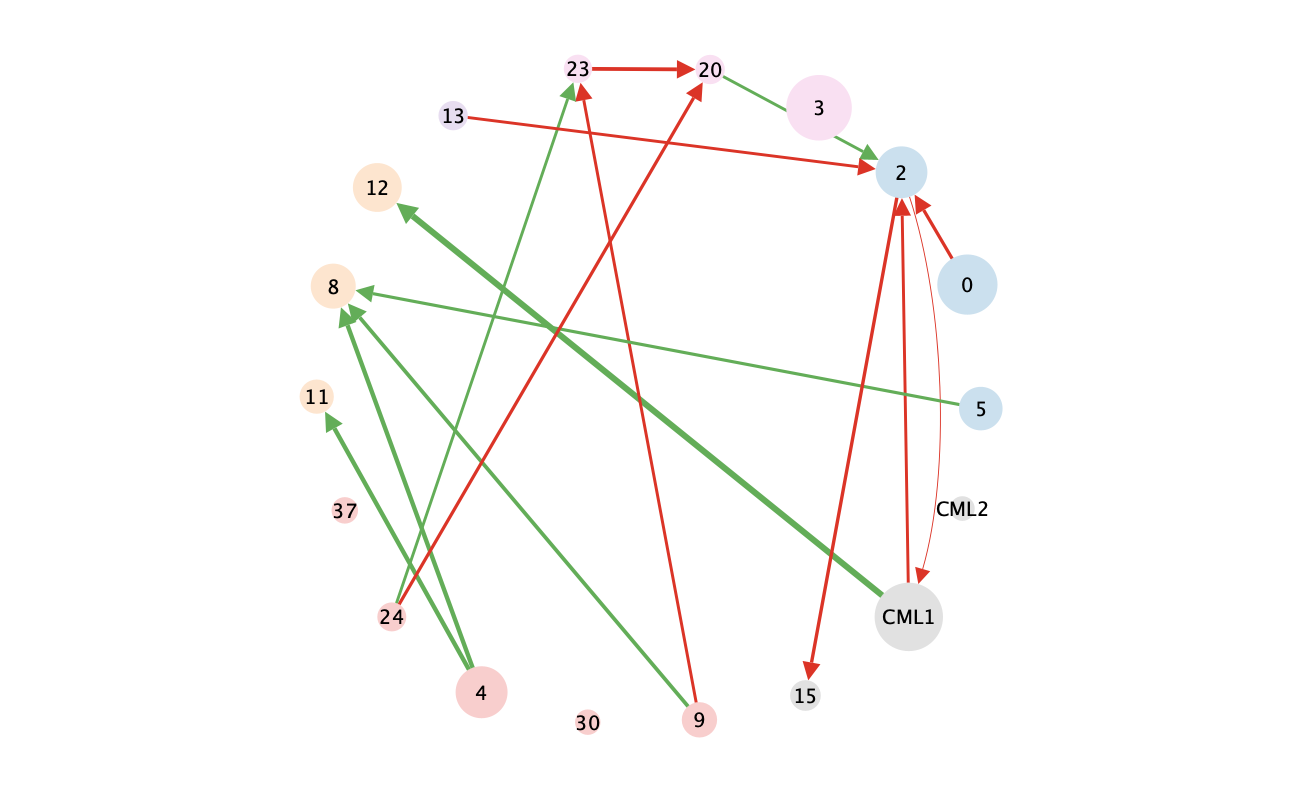

In [44]:
p4c.create_network_from_data_frames(nodes=y_preds_avg_df, 
                                    edges=W_avg_edge_list_df, 
                                    title="AML Responders Post DLI", 
                                    collection="AML Responders Post DLI")

# Default styles
p4c.layout_copycat(source_network='AML Responders Pre DLI', 
                   target_network='AML Responders Post DLI')
p4c.set_node_shape_default('ELLIPSE')
p4c.set_node_width_default(20)
p4c.set_node_height_default(20)
p4c.set_node_font_size_default(8)
p4c.set_edge_target_arrow_shape_default('DELTA_SHORT_1')

# Map style properties to node/edge attributes
p4c.set_node_color_mapping(table_column='shared name', 
                           table_column_values=list(y_preds_avg_df['id']), 
                           colors=clusters_to_colors_hex, 
                           mapping_type='d')
p4c.set_node_size_mapping(table_column='SUID',
                          table_column_values=list(p4c.get_table_columns()['SUID']),
                          sizes=list(p4c.get_table_columns()['Inferred cluster proportion'] * 150 + 10))
p4c.set_edge_color_mapping(table_column='sign(Interaction weight)',
                           table_column_values=[-1.0, 1.0],
                           colors=['#DB3427', '#63AD58'])
p4c.set_edge_target_arrow_color_mapping(table_column='sign(Interaction weight)',
                                        table_column_values=[-1.0, 1.0],
                                        colors=['#DB3427', '#63AD58'])
p4c.set_edge_line_width_mapping(table_column='abs(Interaction weight)', 
                                table_column_values=[W_avg_edge_list_df['abs(Interaction weight)'].min(), 
                                                     W_avg_edge_list_df['abs(Interaction weight)'].max()],
                                widths=[W_avg_edge_list_df['abs(Interaction weight)'].min() * 5, 
                                        W_avg_edge_list_df['abs(Interaction weight)'].max() * 5], 
                                mapping_type='c')
edges_to_hide = [f'{row.source} (interacts with) {row.target}' 
                 for i, row in W_avg_edge_list_df.iterrows()
                 if row['abs(Interaction weight)'] == 0]
p4c.hide_edges(edges_to_hide)

p4c.set_network_center_bypass(0, 0)
p4c.set_network_zoom_bypass(1.5)
p4c.export_image(f'../../figures/CML/interaction_network_R_post_avg.svg', type='SVG')
p4c.export_image(f'../../figures/CML/interaction_network_R_post_avg.png', type='PNG')
p4c.notebook_export_show_image()

## Non-responders model

In [46]:
cells_df_nonresponders = cells_df[cells_df['response'] == 'NONRESPONDER']
cells_df_nonresponders

,x,y,sample,cluster_number,dataset,patient,time,response,aml,DATA,celltypist,cml_Y,vireo,response_group,BM,diisco_cluster,days_to_DLI
7380,9.548580,-1.720452,B3_,16,cml3,NR5322,PRE,NONRESPONDER,x,CML,Early erythroid,0.0,x,CML_NR_PRE,BM,16,-34.0
7381,14.636208,10.843837,B3_,22,cml3,NR5322,PRE,NONRESPONDER,x,CML,Pro-B cells,0.0,x,CML_NR_PRE,BM,22,-34.0
7382,3.494706,13.895420,B3_,3,cml3,NR5322,PRE,NONRESPONDER,x,CML,Naive B cells,0.0,x,CML_NR_PRE,BM,3,-34.0
7383,9.470916,0.884524,B3_,16,cml3,NR5322,PRE,NONRESPONDER,x,CML,Neutrophil-myeloid progenitor,0.0,x,CML_NR_PRE,BM,16,-34.0
7384,-4.625113,2.802856,B3_,5,cml3,NR5322,PRE,NONRESPONDER,x,CML,Tem/Trm cytotoxic T cells,0.0,x,CML_NR_PRE,BM,5,-34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263767,13.297939,4.122573,B43_,15,cml3,NR5321,PRE,NONRESPONDER,x,CML,Double-negative thymocytes,0.0,x,CML_NR_PRE,BM,15,0.0
263768,12.078852,4.221736,B43_,15,cml3,NR5321,PRE,NONRESPONDER,x,CML,Neutrophil-myeloid progenitor,0.0,x,CML_NR_PRE,BM,15,0.0
263769,12.587338,-3.705819,B43_,8,cml3,NR5321,PRE,NONRESPONDER,x,CML,Mid erythroid,0.0,x,CML_NR_PRE,BM,8,0.0
263770,12.453655,5.030026,B43_,15,cml3,NR5321,PRE,NONRESPONDER,x,CML,Double-negative thymocytes,0.0,x,CML_NR_PRE,BM,15,0.0


In [47]:
clusters_of_interest = {
    '0': 'T cell',
    '1': 'NK cell',
    '10': 'AML',
    '11': 'Erythroid',
    '12': 'Erythroid',
    '15': 'AML',
    '16': 'Erythroid',
    '2': 'T cell',
    '22': 'B cell',
    '25': 'T cell',
    '3': 'B cell',
    '30': 'Myeloid', 
    '37': 'Myeloid',
    '4': 'Myeloid',
    '41': 'Myeloid',
    '5': 'T cell',
    '8': 'Erythroid',
    '9': 'Myeloid', 
    'CML1': 'CML',
    'CML2': 'CML'
}

colors = {
    'T cell': 'tab:blue',
    'B cell': 'tab:pink',
    'Myeloid': 'tab:red',
    'AML': 'tab:gray',
    'CML': 'tab:gray',
    'HSC': 'goldenrod',
    'NK cell': 'tab:purple',
    'Erythroid': 'tab:orange'
}

In [48]:
sample_cluster_proportions = []

all_clusters = sorted(cells_df_nonresponders['diisco_cluster'].unique())
for sample, sample_df in cells_df_nonresponders.groupby('sample'):
    cluster_proportions = sample_df['diisco_cluster'].value_counts(normalize=True)
    cluster_proportions_dict = {cluster: (cluster_proportions[cluster] 
                                          if cluster in cluster_proportions
                                          else 0)
                                for cluster in all_clusters}
    sample_cluster_proportions.append({
        'sample': sample,
        'days_to_DLI': sample_df.iloc[0]['days_to_DLI'],
        **cluster_proportions_dict
    })
    
sample_cluster_proportions_all_df = pd.DataFrame(sample_cluster_proportions)
sample_cluster_proportions_all_df = sample_cluster_proportions_all_df.sort_values('days_to_DLI')
sample_cluster_proportions_all_df

,sample,days_to_DLI,0,1,10,11,12,13,14,15,...,5,50,51,52,54,55,8,9,CML1,CML2
5,B3_,-34.0,0.015243,0.019319,0.000177,0.015420,0.005140,0.001950,0.022687,0.018433,...,0.030663,0.000354,0.001063,0.008508,0.000000,0.001063,0.050337,0.077987,0.041120,0.000177
0,B17_,-15.0,0.090172,0.055222,0.011184,0.021809,0.048511,0.028939,0.000140,0.096323,...,0.075493,0.000280,0.000979,0.000140,0.000000,0.000000,0.010066,0.015238,0.165944,0.025164
1,B19_,-4.0,0.019505,0.052867,0.179493,0.097954,0.059902,0.003411,0.000213,0.038265,...,0.006928,0.000107,0.014496,0.000000,0.054359,0.000107,0.000426,0.009060,0.291409,0.000426
3,B27_,0.0,0.080303,0.026982,0.000899,0.063215,0.088912,0.008737,0.002827,0.035719,...,0.046126,0.000257,0.000771,0.000000,0.000000,0.000000,0.010150,0.024412,0.342927,0.000257
7,B43_,0.0,0.008726,0.002641,0.001722,0.036625,0.009300,0.001148,0.000230,0.128243,...,0.020781,0.000115,0.000918,0.000804,0.000000,0.004937,0.037084,0.047876,0.242824,0.004592
9,B7_,0.0,0.162455,0.020091,0.000157,0.043635,0.037828,0.001099,0.013813,0.010987,...,0.059802,0.000471,0.004709,0.000471,0.000000,0.001570,0.107048,0.012714,0.304034,0.000000
2,B20_,129.0,0.019268,0.062087,0.681653,0.006050,0.029321,0.002420,0.000000,0.005120,...,0.002234,0.000000,0.036489,0.000000,0.001117,0.000000,0.000000,0.001862,0.005399,0.000000
8,B4_,164.0,0.012314,0.010104,0.001053,0.019051,0.014209,0.001579,0.026945,0.031155,...,0.029260,0.000211,0.000211,0.002526,0.000000,0.000421,0.030944,0.155036,0.043259,0.001053
4,B28_,182.0,0.129825,0.113840,0.000000,0.104094,0.247563,0.010136,0.000000,0.003509,...,0.019493,0.000000,0.002729,0.000000,0.000000,0.000000,0.003899,0.010526,0.086160,0.000780
10,B8_,252.0,0.014965,0.082619,0.000156,0.034606,0.021980,0.016056,0.000000,0.000935,...,0.008106,0.000156,0.000312,0.000000,0.000000,0.000468,0.007794,0.001247,0.106157,0.002027


In [49]:
sample_cluster_proportions_df = sample_cluster_proportions_all_df[['sample', 'days_to_DLI'] 
                                                                  + list(clusters_of_interest.keys())]
sample_cluster_proportions_df

,sample,days_to_DLI,0,1,10,11,12,15,16,2,...,3,30,37,4,41,5,8,9,CML1,CML2
5,B3_,-34.0,0.015243,0.019319,0.000177,0.015420,0.005140,0.018433,0.172634,0.040057,...,0.135236,0.002481,0.001772,0.216058,0.005495,0.030663,0.050337,0.077987,0.041120,0.000177
0,B17_,-15.0,0.090172,0.055222,0.011184,0.021809,0.048511,0.096323,0.002377,0.117014,...,0.112121,0.007689,0.040123,0.005592,0.018174,0.075493,0.010066,0.015238,0.165944,0.025164
1,B19_,-4.0,0.019505,0.052867,0.179493,0.097954,0.059902,0.038265,0.003624,0.025048,...,0.011298,0.075464,0.003198,0.005862,0.036666,0.006928,0.000426,0.009060,0.291409,0.000426
3,B27_,0.0,0.080303,0.026982,0.000899,0.063215,0.088912,0.035719,0.005653,0.086856,...,0.027496,0.014133,0.046512,0.050880,0.006810,0.046126,0.010150,0.024412,0.342927,0.000257
7,B43_,0.0,0.008726,0.002641,0.001722,0.036625,0.009300,0.128243,0.304592,0.013433,...,0.004707,0.014811,0.031458,0.060620,0.006659,0.020781,0.037084,0.047876,0.242824,0.004592
9,B7_,0.0,0.162455,0.020091,0.000157,0.043635,0.037828,0.010987,0.006121,0.017737,...,0.058547,0.006592,0.019934,0.045833,0.003296,0.059802,0.107048,0.012714,0.304034,0.000000
2,B20_,129.0,0.019268,0.062087,0.681653,0.006050,0.029321,0.005120,0.000093,0.008005,...,0.000465,0.124081,0.000279,0.002606,0.000279,0.002234,0.000000,0.001862,0.005399,0.000000
8,B4_,164.0,0.012314,0.010104,0.001053,0.019051,0.014209,0.031155,0.005157,0.024839,...,0.058941,0.003158,0.002316,0.361751,0.015051,0.029260,0.030944,0.155036,0.043259,0.001053
4,B28_,182.0,0.129825,0.113840,0.000000,0.104094,0.247563,0.003509,0.002729,0.124366,...,0.016374,0.001949,0.021053,0.045224,0.002339,0.019493,0.003899,0.010526,0.086160,0.000780
10,B8_,252.0,0.014965,0.082619,0.000156,0.034606,0.021980,0.000935,0.001091,0.101949,...,0.007950,0.000468,0.004988,0.000000,0.000468,0.008106,0.007794,0.001247,0.106157,0.002027


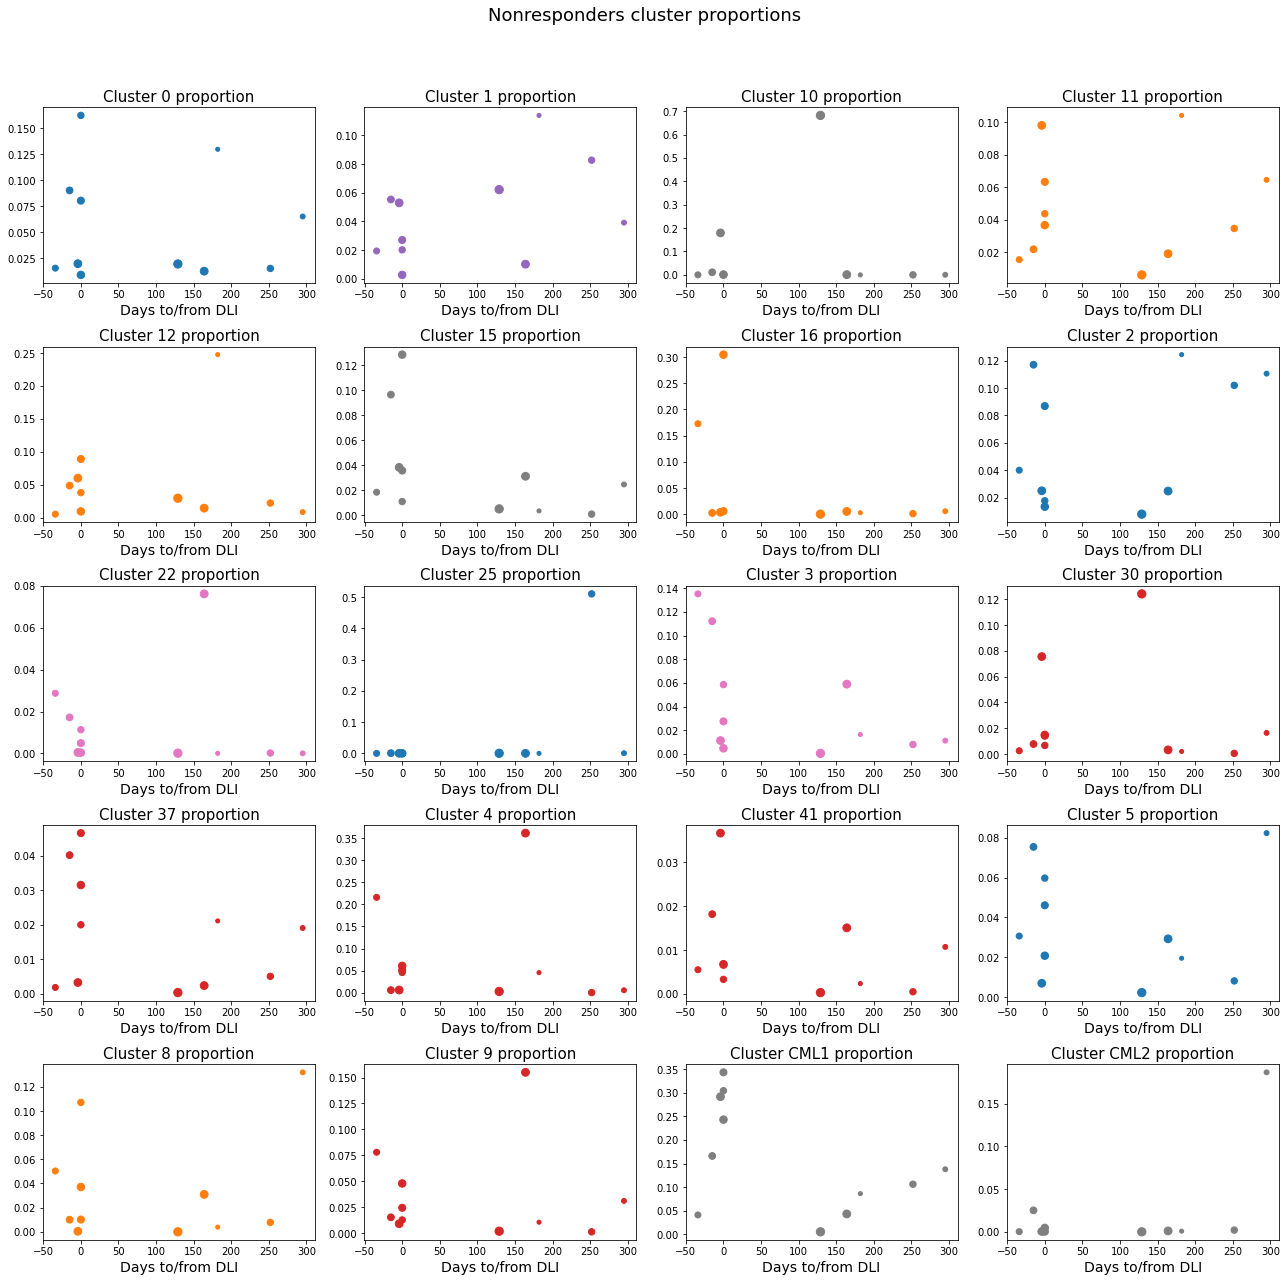

In [50]:
cells_per_sample = cells_df_nonresponders['sample'].value_counts(normalize=True)[sample_cluster_proportions_df['sample']]

plt.figure(figsize=(18, 20))
for i, cluster in enumerate(clusters_of_interest):
    color = colors[list(clusters_of_interest.values())[i]]
    plt.subplot(6, 4, i+1)
    plt.scatter(sample_cluster_proportions_df['days_to_DLI'], 
                sample_cluster_proportions_df[cluster], 
                s=cells_per_sample*500, 
                color=color)
    plt.title(f'Cluster {cluster} proportion', fontsize=15)
    plt.xlabel('Days to/from DLI', fontsize=14)
plt.suptitle(f'Nonresponders cluster proportions', y=1.03, fontsize=18)
plt.tight_layout()
plt.savefig('../../figures/CML/cell_type_proportions_NR.eps', bbox_inches='tight')

In [51]:
cluster_means = sample_cluster_proportions_df[clusters_of_interest].mean()
cluster_std_devs = sample_cluster_proportions_df[clusters_of_interest].std()
sample_cluster_proportions_df.loc[:, clusters_of_interest] -= cluster_means
sample_cluster_proportions_df.loc[:, clusters_of_interest] /= cluster_std_devs
sample_cluster_proportions_df

/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_16212/858897236.py:1: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  cluster_means = sample_cluster_proportions_df[clusters_of_interest].mean()
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_16212/858897236.py:2: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  cluster_std_devs = sample_cluster_proportions_df[clusters_of_interest].std()
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_16212/858897236.py:3: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  sample_cluster_proportions_df.loc[:, clusters_of_interest] -= cluster_means
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_16212/858897236.py:3: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a 

,sample,days_to_DLI,0,1,10,11,12,15,16,2,...,3,30,37,4,41,5,8,9,CML1,CML2
5,B3_,-34.0,-0.762628,-0.737951,-0.384949,-0.934091,-0.670438,-0.426720,1.268594,-0.444919,...,2.061038,-0.555441,-0.946051,1.257726,-0.388604,-0.144145,0.331739,0.935276,-1.014220,-0.357520
0,B17_,-15.0,0.633797,0.332212,-0.331688,-0.739483,-0.048663,1.492060,-0.441543,1.198373,...,1.558700,-0.422784,1.386011,-0.588852,0.802606,1.470861,-0.564144,-0.435759,0.045008,0.090559
1,B19_,-4.0,-0.683187,0.262033,0.482744,1.579878,0.114637,0.061821,-0.429015,-0.765406,...,-0.632394,1.303653,-0.859386,-0.586481,2.539838,-0.999193,-0.778584,-0.570757,1.109671,-0.353053
3,B27_,0.0,0.449877,-0.509549,-0.381455,0.521733,0.530526,-0.000896,-0.408631,0.554402,...,-0.280385,-0.258627,1.774495,-0.191505,-0.265045,0.412923,-0.562261,-0.235313,1.546839,-0.356090
7,B43_,0.0,-0.884087,-1.235107,-0.377474,-0.288202,-0.610805,2.278397,2.594044,-1.013428,...,-0.775631,-0.241377,0.859105,-0.106050,-0.279203,-0.500152,0.036910,0.277367,0.697393,-0.278345
9,B7_,0.0,1.980906,-0.714950,-0.385047,-0.074657,-0.201823,-0.610146,-0.403928,-0.921528,...,0.394415,-0.450721,0.158341,-0.235790,-0.595128,0.905605,1.593346,-0.490918,1.216803,-0.360698
2,B20_,129.0,-0.687606,0.536853,2.912660,-1.219489,-0.323770,-0.754693,-0.464480,-1.129326,...,-0.867815,2.542089,-1.036849,-0.615047,-0.878558,-1.168300,-0.788069,-0.728036,-1.317342,-0.360698
8,B4_,164.0,-0.817202,-1.012635,-0.380714,-0.823504,-0.540423,-0.113334,-0.413613,-0.769858,...,0.402991,-0.538217,-0.913024,2.536002,0.509198,-0.194681,-0.099676,2.618797,-0.996074,-0.341824
4,B28_,182.0,1.372787,2.079499,-0.385807,1.766903,2.804980,-0.794375,-0.438004,1.355377,...,-0.522081,-0.568995,0.226360,-0.241129,-0.685035,-0.546536,-0.701339,-0.538716,-0.632024,-0.346716
10,B8_,252.0,-0.767807,1.148863,-0.385053,-0.349675,-0.429021,-0.857771,-0.454455,0.876679,...,-0.705156,-0.606737,-0.750496,-0.637915,-0.860858,-0.956761,-0.614676,-0.741465,-0.462329,-0.324358


In [52]:
X = sample_cluster_proportions_df['days_to_DLI'].values.reshape(-1, 1)
X

array([[-34.],
       [-15.],
       [ -4.],
       [  0.],
       [  0.],
       [  0.],
       [129.],
       [164.],
       [182.],
       [252.],
       [295.]])

In [53]:
Y = sample_cluster_proportions_df[clusters_of_interest].values
Y[:5]

/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_16212/2580917083.py:1: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  Y = sample_cluster_proportions_df[clusters_of_interest].values


array([[-7.62628136e-01, -7.37950977e-01, -3.84949335e-01,
        -9.34090577e-01, -6.70437707e-01, -4.26720013e-01,
         1.26859441e+00, -4.44918847e-01,  6.96144315e-01,
        -3.02572866e-01,  2.06103831e+00, -5.55440951e-01,
        -9.46050523e-01,  1.25772576e+00, -3.88603803e-01,
        -1.44145066e-01,  3.31738904e-01,  9.35275529e-01,
        -1.01421994e+00, -3.57519907e-01],
       [ 6.33796969e-01,  3.32211969e-01, -3.31687910e-01,
        -7.39482722e-01, -4.86631813e-02,  1.49206026e+00,
        -4.41543389e-01,  1.19837344e+00,  1.96529718e-01,
        -2.98028905e-01,  1.55870012e+00, -4.22784188e-01,
         1.38601088e+00, -5.88851536e-01,  8.02605728e-01,
         1.47086067e+00, -5.64143921e-01, -4.35758632e-01,
         4.50079759e-02,  9.05591209e-02],
       [-6.83187454e-01,  2.62032862e-01,  4.82744048e-01,
         1.57987757e+00,  1.14637412e-01,  6.18206123e-02,
        -4.29014605e-01, -7.65405991e-01, -5.30889620e-01,
        -3.01187108e-01, -6.3

Text(0.5, 1.02, 'Interaction prior variances for nonresponders based on receptor-ligand expression')

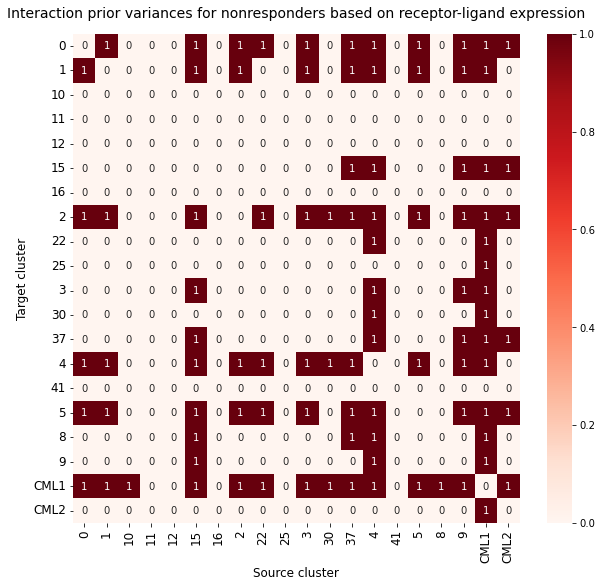

In [54]:
W_prior_variance = np.load('../../data/CML/nonresponder_interaction_prior.npy')

plt.figure(figsize=(10, 9))
ax = sns.heatmap(W_prior_variance, cmap="Reds", annot=True)
ax.set_yticklabels(clusters_of_interest, fontsize=12, rotation=0)
ax.set_xticklabels(clusters_of_interest, fontsize=12, rotation=90)
plt.xlabel('Source cluster', fontsize=12)
plt.ylabel('Target cluster', fontsize=12)
plt.title('Interaction prior variances for nonresponders based on receptor-ligand expression', 
          fontsize=14, y=1.02)

In [55]:
timepoints = torch.tensor(X)
proportions = torch.tensor(Y)
prior_matrix = torch.tensor(W_prior_variance)
n_timepoints, n_cell_types = proportions.shape

print('timepoints.shape:', timepoints.shape)
print('cell_types.shape:', proportions.shape)

timepoints.shape: torch.Size([11, 1])
cell_types.shape: torch.Size([11, 20])


In [56]:
def unscale(proportions, cluster_index): 
    return np.clip((proportions * 
                    cluster_std_devs.values[cluster_index] + 
                    cluster_means.values[cluster_index]), 
                   0, 1)

In [57]:
# mean of all intervals
lengthscale = np.mean(np.abs(X - X.T))
lengthscale

123.2396694214876

In [58]:
hyper_init_vals = {
    names.LENGTHSCALE_F: 100,
    names.LENGTHSCALE_W: 100,
    names.SIGMA_F: 1,
    names.VARIANCE_F: 1,
    names.SIGMA_W: 0.1,
    names.VARIANCE_W: 1,
    names.SIGMA_Y: 0.1,
}
print(hyper_init_vals)

{'lengthscale_f': 100, 'lengthscale_w': 100, 'sigma_f': 1, 'variance_f': 1, 'sigma_w': 0.1, 'variance_w': 1, 'sigma_y': 0.1}


In [19]:
model = DIISCO(lambda_matrix=prior_matrix, hypers_init_vals=hyper_init_vals, verbose=True, verbose_freq=100)

Text(0.5, 0.95, 'Independent GP fits to set $f_i$ latent functions')

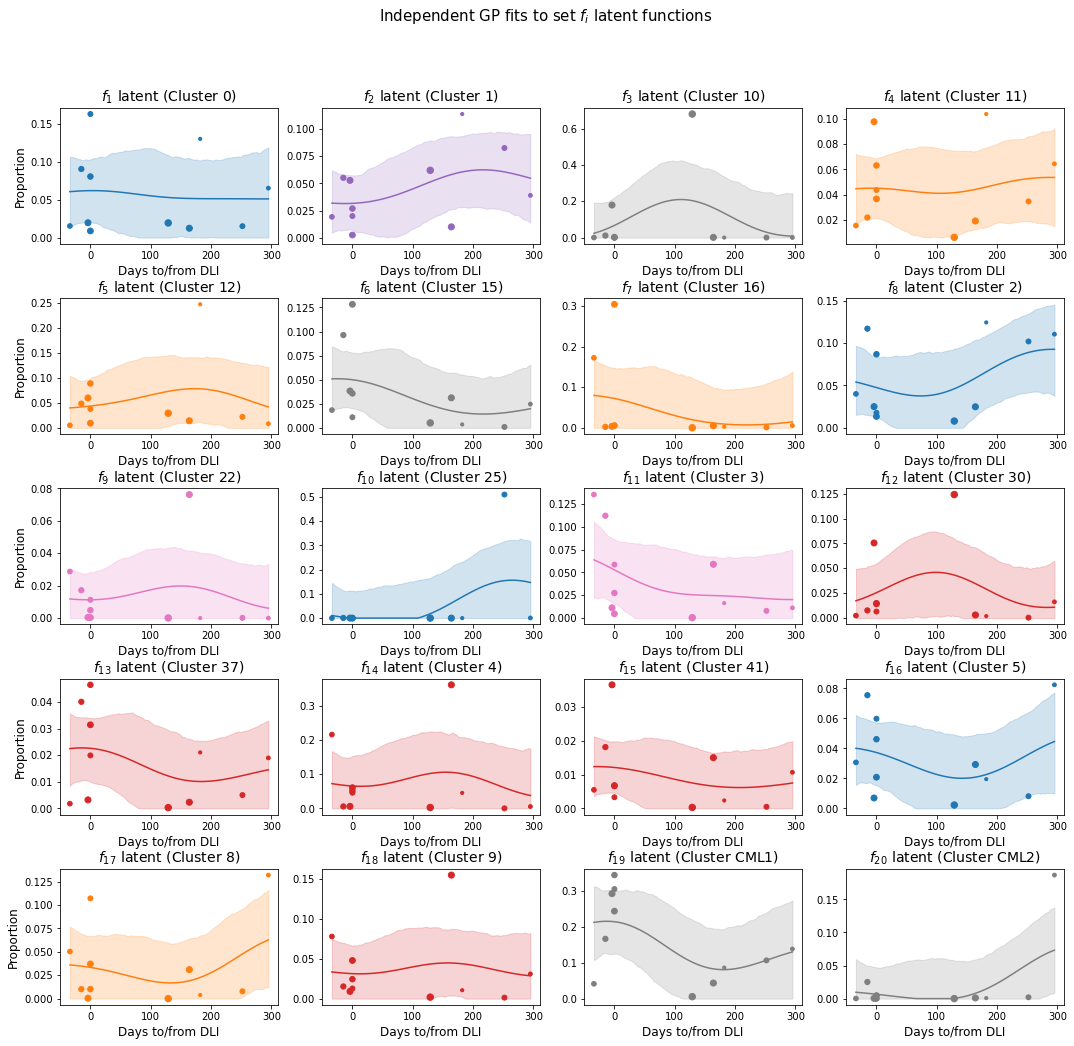

In [20]:
model.fit_and_set_f_prior_params(timepoints=timepoints, proportions=proportions, hypers=model.hypers_init_vals)
eval_timepoints = torch.linspace(timepoints.min(), timepoints.max(), 100).view(-1, 1)

n_samples = 1000
n_eval_timepoints = eval_timepoints.shape[0]
f_prior_np = model.sample_f_prior(eval_timepoints, n_samples=n_samples)

plt.figure(figsize=(18, 20))
for i, cluster in enumerate(clusters_of_interest):
    eval_timepoints_np = eval_timepoints.detach().numpy()
    f_prior_cell_type_np = f_prior_np[:, i, :].detach().numpy()
    mean = unscale(f_prior_cell_type_np.mean(axis=0), i)
    upper = unscale(np.percentile(f_prior_cell_type_np, 97.5, axis=0), i)
    lower = unscale(np.percentile(f_prior_cell_type_np, 2.5, axis=0), i)
    plt.subplot(6, 4, i+1)
    color = colors[list(clusters_of_interest.values())[i]]
#     color = 'tab:blue'
    plt.plot(eval_timepoints_np, mean, c=color)
    plt.scatter(timepoints, unscale(proportions[:, i].flatten().detach().numpy(), i), 
                c=color, s=cells_per_sample*300)
    plt.fill_between(eval_timepoints_np.flatten(), lower, upper, color=color, alpha=0.2)
    plt.title('$f_{%s}$ latent (Cluster %s)' % (i+1, cluster), fontsize=14)
    plt.xlabel('Days to/from DLI', fontsize=12)
    if i%4==0: plt.ylabel('Proportion', fontsize=12)
plt.subplots_adjust(hspace=0.4)
plt.suptitle('Independent GP fits to set $f_i$ latent functions', fontsize=15, y=0.95)

In [21]:
model.fit(timepoints, 
          proportions, 
          n_iter=100000, 
          lr=0.00001, 
          hypers_to_optim=[], 
          guide="MultivariateNormalFactorized")

[iteration 0001] loss: 1958945.3441
[iteration 0101] loss: 1372372.3252
[iteration 0201] loss: 1294752.1103
[iteration 0301] loss: 1255186.8744
[iteration 0401] loss: 1221801.5645
[iteration 0501] loss: 1199178.1010
[iteration 0601] loss: 1178020.6514
[iteration 0701] loss: 1161057.5260
[iteration 0801] loss: 1147549.9242
[iteration 0901] loss: 1130146.7488
[iteration 1001] loss: 1119167.5626
[iteration 1101] loss: 1108193.0703
[iteration 1201] loss: 1094104.4102
[iteration 1301] loss: 1083931.2275
[iteration 1401] loss: 1074659.0426
[iteration 1501] loss: 1065659.0824
[iteration 1601] loss: 1058950.7801
[iteration 1701] loss: 1049979.0199
[iteration 1801] loss: 1043369.0283
[iteration 1901] loss: 1034005.2504
[iteration 2001] loss: 1026439.7474
[iteration 2101] loss: 1019938.4386
[iteration 2201] loss: 1012558.8187
[iteration 2301] loss: 1008012.2968
[iteration 2401] loss: 1000955.8270
[iteration 2501] loss: 993059.2552
[iteration 2601] loss: 984768.1080
[iteration 2701] loss: 984207.

[iteration 23001] loss: 512016.4251
[iteration 23101] loss: 514406.8130
[iteration 23201] loss: 511606.0737
[iteration 23301] loss: 513647.7110
[iteration 23401] loss: 511516.4005
[iteration 23501] loss: 507388.0601
[iteration 23601] loss: 509159.8618
[iteration 23701] loss: 513681.3954
[iteration 23801] loss: 505182.4239
[iteration 23901] loss: 506098.9223
[iteration 24001] loss: 504511.7527
[iteration 24101] loss: 504487.2558
[iteration 24201] loss: 502667.9941
[iteration 24301] loss: 505417.8897
[iteration 24401] loss: 501621.2089
[iteration 24501] loss: 503218.7397
[iteration 24601] loss: 503319.8761
[iteration 24701] loss: 497476.2463
[iteration 24801] loss: 499307.1354
[iteration 24901] loss: 500387.6878
[iteration 25001] loss: 500051.2256
[iteration 25101] loss: 498955.4008
[iteration 25201] loss: 499079.0403
[iteration 25301] loss: 502616.0224
[iteration 25401] loss: 494733.8482
[iteration 25501] loss: 497072.8874
[iteration 25601] loss: 492391.7859
[iteration 25701] loss: 4923

[iteration 45801] loss: 420300.9138
[iteration 45901] loss: 424632.5357
[iteration 46001] loss: 419571.7442
[iteration 46101] loss: 421450.5002
[iteration 46201] loss: 418080.9810
[iteration 46301] loss: 418894.9831
[iteration 46401] loss: 418650.2242
[iteration 46501] loss: 420329.5000
[iteration 46601] loss: 421556.8861
[iteration 46701] loss: 420436.2501
[iteration 46801] loss: 419494.1394
[iteration 46901] loss: 419317.1689
[iteration 47001] loss: 418794.1570
[iteration 47101] loss: 416186.2398
[iteration 47201] loss: 416172.5263
[iteration 47301] loss: 416344.7267
[iteration 47401] loss: 422172.4686
[iteration 47501] loss: 417330.9685
[iteration 47601] loss: 417184.0600
[iteration 47701] loss: 419782.4887
[iteration 47801] loss: 417114.7162
[iteration 47901] loss: 418460.1906
[iteration 48001] loss: 420159.8298
[iteration 48101] loss: 417824.1565
[iteration 48201] loss: 414947.2535
[iteration 48301] loss: 415289.8238
[iteration 48401] loss: 416343.4193
[iteration 48501] loss: 4151

[iteration 68601] loss: 386502.0877
[iteration 68701] loss: 385132.9418
[iteration 68801] loss: 387321.3610
[iteration 68901] loss: 388255.3374
[iteration 69001] loss: 385891.3099
[iteration 69101] loss: 385286.2293
[iteration 69201] loss: 385804.9163
[iteration 69301] loss: 384521.2365
[iteration 69401] loss: 384132.6531
[iteration 69501] loss: 382015.9823
[iteration 69601] loss: 385464.4513
[iteration 69701] loss: 384692.3485
[iteration 69801] loss: 379922.7142
[iteration 69901] loss: 386708.8116
[iteration 70001] loss: 382356.9130
[iteration 70101] loss: 385243.6027
[iteration 70201] loss: 383021.9754
[iteration 70301] loss: 382535.5374
[iteration 70401] loss: 383890.7907
[iteration 70501] loss: 382825.5313
[iteration 70601] loss: 380044.4742
[iteration 70701] loss: 383587.6426
[iteration 70801] loss: 382303.1164
[iteration 70901] loss: 382334.2780
[iteration 71001] loss: 380853.8295
[iteration 71101] loss: 381143.0365
[iteration 71201] loss: 382759.8157
[iteration 71301] loss: 3812

[iteration 91401] loss: 359774.9358
[iteration 91501] loss: 361587.0531
[iteration 91601] loss: 362273.5590
[iteration 91701] loss: 360847.1364
[iteration 91801] loss: 359387.5187
[iteration 91901] loss: 359169.8591
[iteration 92001] loss: 361701.3621
[iteration 92101] loss: 359595.3304
[iteration 92201] loss: 356320.0965
[iteration 92301] loss: 363853.5004
[iteration 92401] loss: 358753.3508
[iteration 92501] loss: 358965.3133
[iteration 92601] loss: 360692.3567
[iteration 92701] loss: 358401.2453
[iteration 92801] loss: 358191.1125
[iteration 92901] loss: 362607.8009
[iteration 93001] loss: 359434.2434
[iteration 93101] loss: 360463.6190
[iteration 93201] loss: 360160.8669
[iteration 93301] loss: 361515.0713
[iteration 93401] loss: 363248.4497
[iteration 93501] loss: 359956.1358
[iteration 93601] loss: 360067.3846
[iteration 93701] loss: 358105.6940
[iteration 93801] loss: 356247.1403
[iteration 93901] loss: 359243.8030
[iteration 94001] loss: 355906.4113
[iteration 94101] loss: 3602

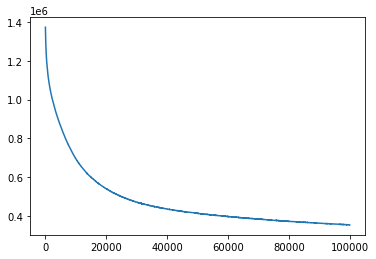

In [22]:
start = 50
loss_moving_avg = np.convolve(model.losses[start:], np.ones(100)/100, 'valid')
plt.plot(loss_moving_avg)

In [23]:
predict_timepoints = torch.linspace(timepoints.min(), timepoints.max(), 100).reshape(-1, 1)
means = model.get_means(predict_timepoints)

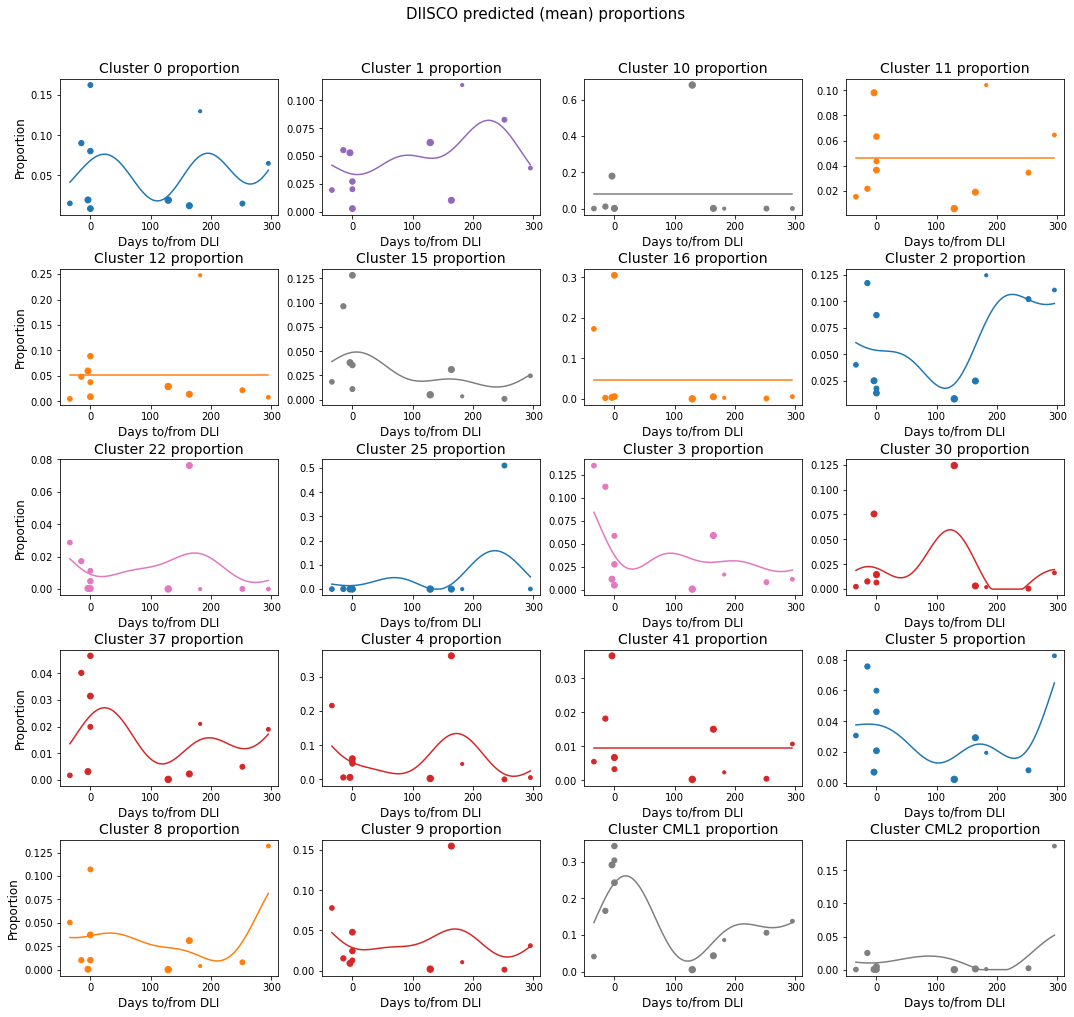

In [24]:
from mimic_alpha.mimic_alpha import colorAlpha_to_rgb
import matplotlib.colors as colors2

plt.figure(figsize=(18, 20))
for i, cluster in enumerate(clusters_of_interest):
    mean = unscale(means['Y'][:, i], i)
    x = predict_timepoints.squeeze().numpy()
    plt.subplot(6, 4, i+1)
    color = colors[list(clusters_of_interest.values())[i]]
    plt.plot(x, mean, c=color)
    plt.scatter(timepoints, unscale(proportions[:, i], i), c=color, s=cells_per_sample*300)
    plt.title(f'Cluster {cluster} proportion', fontsize=14)
    plt.xlabel('Days to/from DLI', fontsize=12)
    if i%4==0: plt.ylabel('Proportion', fontsize=12)
    
plt.suptitle('DIISCO predicted (mean) proportions', fontsize=15, y=0.93)
plt.subplots_adjust(hspace=0.4)

In [25]:
predict_timepoints = torch.linspace(timepoints.min(), timepoints.max(), 100).reshape(-1, 1)
samples = model.sample(predict_timepoints, 
                 n_samples=10000, 
                 n_samples_per_latent=10,
                 include_emission_variance=False)

100%|██████████████████████████████████████| 10000/10000 [05:52<00:00, 28.39it/s]


In [26]:
W_samples_predict = samples['W']
f_samples_predict = samples['F']
y_samples_predict = samples['Y']

In [27]:
y_preds = y_samples_predict.mean(axis=0).numpy()

np.save('../../data/CML/X_NR.npy', predict_timepoints.numpy())
np.save('../../data/CML/y_preds_NR.npy', y_preds)
np.save('../../data/CML/W_samples_predict_NR.npy', W_samples_predict)
np.save('../../data/CML/y_samples_predict_NR.npy', y_samples_predict)

In [59]:
predict_timepoints = np.load('../../data/CML/X_NR.npy')
y_preds = np.load('../../data/CML/y_preds_NR.npy')
W_samples_predict = np.load('../../data/CML/W_samples_predict_NR.npy')
y_samples_predict = np.load('../../data/CML/y_samples_predict_NR.npy')

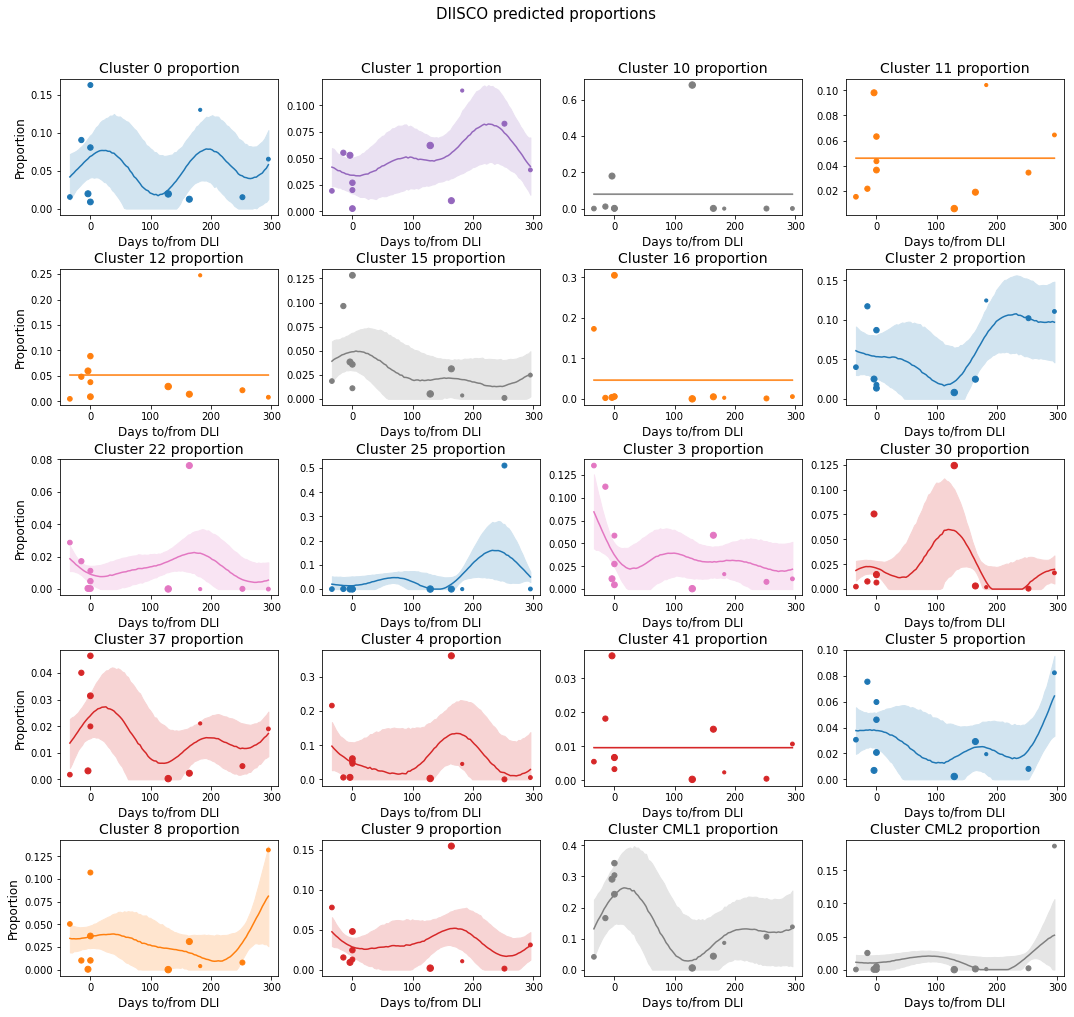

In [60]:
from mimic_alpha.mimic_alpha import colorAlpha_to_rgb
import matplotlib.colors as colors2

plt.figure(figsize=(18, 20))
for i, cluster in enumerate(clusters_of_interest):
    cell_type_samples = y_samples_predict[:, :, i]
    mean = unscale(cell_type_samples.mean(axis=0), i)
    x = predict_timepoints.squeeze()
    percentile_75 = unscale(np.percentile(cell_type_samples, 84, axis=0), i)
    percentile_25 = unscale(np.percentile(cell_type_samples, 16, axis=0), i)
    plt.subplot(6, 4, i+1)
    color = colors[list(clusters_of_interest.values())[i]]
    plt.plot(x, mean, c=color)
    color_with_alpha = list(colors2.to_rgb(color)) + [0.2]
    color_without_alpha = colorAlpha_to_rgb([color_with_alpha], 0.2)
    plt.fill_between(x, percentile_25, percentile_75, color=color_without_alpha)
    plt.scatter(timepoints, unscale(proportions[:, i], i), c=color, s=cells_per_sample*300)
    plt.title(f'Cluster {cluster} proportion', fontsize=14)
    plt.xlabel('Days to/from DLI', fontsize=12)
    if i%4==0: plt.ylabel('Proportion', fontsize=12)
    
plt.suptitle('DIISCO predicted proportions', fontsize=15, y=0.93)
plt.subplots_adjust(hspace=0.4)
plt.savefig('../../figures/CML/diisco_predictions_NR.eps')

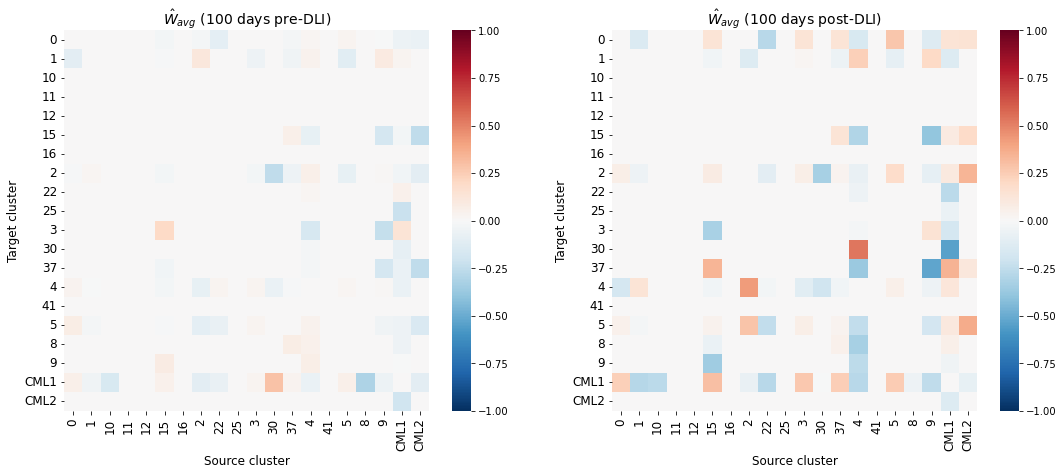

In [61]:
annot = False
vmin = -1
vmax = 1

X_100_days_pre_dli_index = np.where(predict_timepoints > -100)[0][0]
X_post_dli_index = np.where(predict_timepoints > 0)[0][0]
X_100_days_post_dli_index = np.where(predict_timepoints > 95)[0][0]
X_post_dli_index

W = W_samples_predict.mean(axis=0)
W_pre_dli = W[X_100_days_pre_dli_index:X_post_dli_index]
W_post_dli = W[X_post_dli_index:X_100_days_post_dli_index]
W_pre_dli_avg_over_time = np.mean(W_pre_dli, axis=0)
W_post_dli_avg_over_time = np.mean(W_post_dli, axis=0)

plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
ax = sns.heatmap(W_pre_dli_avg_over_time, cmap="RdBu_r", annot=annot, 
                 fmt='.2f', vmin=vmin, vmax=vmax, center=0)
ax.set_yticklabels(clusters_of_interest, fontsize=12)
ax.set_xticklabels(clusters_of_interest, fontsize=12)
plt.xlabel('Source cluster', fontsize=12)
plt.ylabel('Target cluster', fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.title('$\hat{W}_{avg}$ (100 days pre-DLI)', fontsize=14)

plt.subplot(1, 2, 2)
ax = sns.heatmap(W_post_dli_avg_over_time, cmap="RdBu_r", annot=annot, 
                 fmt='.2f', vmin=vmin, vmax=vmax, center=0)
ax.set_yticklabels(clusters_of_interest, fontsize=12)
ax.set_xticklabels(clusters_of_interest, fontsize=12)
plt.xlabel('Source cluster', fontsize=12)
plt.ylabel('Target cluster', fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.title('$\hat{W}_{avg}$ (100 days post-DLI)', fontsize=14)
plt.savefig('../../figures/CML/W_avg_pre_post_DLI_NR.eps')

In [62]:
y_samples_predict_unscaled = [unscale(y_samples_predict[:, :, i], i) 
                              for i in range(len(clusters_of_interest))]
y_samples_predict_unscaled = np.dstack(y_samples_predict_unscaled)
y_samples_predict_unscaled.shape

(10000, 100, 20)

In [63]:
y_mu = y_samples_predict_unscaled.mean(axis=0).mean(axis=0)
y_sigma = y_samples_predict_unscaled.std(axis=0).mean(axis=0)

y_mu_over_sigma = np.array(y_mu) / np.array(y_sigma)

(0.0, 2.0)

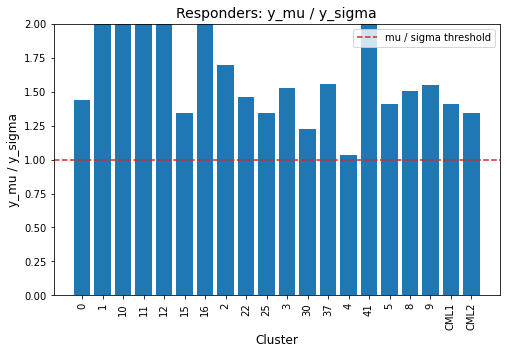

In [64]:
plt.figure(figsize=(8, 5))
mu_sigma_threshold = 1.0
plt.bar(range(len(y_mu_over_sigma)), y_mu_over_sigma)
plt.xticks(range(len(y_mu_over_sigma)), clusters_of_interest, rotation=90)
plt.axhline(mu_sigma_threshold, c='tab:red', linestyle='--', label='mu / sigma threshold')
plt.legend(loc='upper right')
plt.title("Responders: y_mu / y_sigma", fontsize=14)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("y_mu / y_sigma", fontsize=12)
plt.ylim([0, 2])

In [65]:
mean_abs_W_threshold = 0.3
max_abs_W_threshold = 1
mu_sigma_threshold = 1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


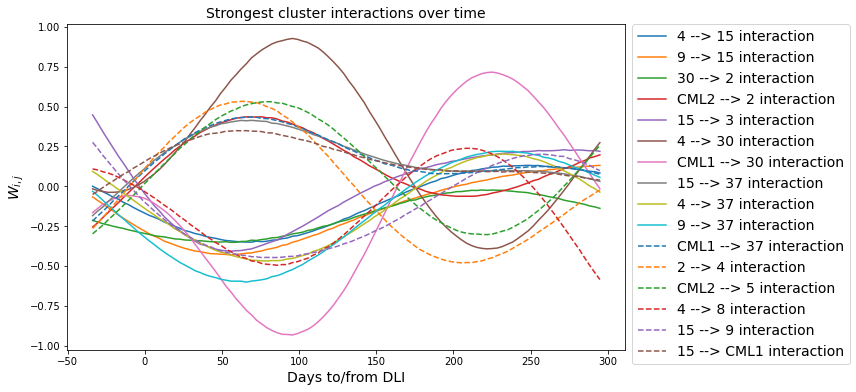

In [66]:
plt.figure(figsize=(10, 6))
linestyles = ['-', '--', ":"]
lines = 0
for i, cluster_i in enumerate(clusters_of_interest):
    for j, cluster_j in enumerate(clusters_of_interest):
        # a sustained strong interaction over the entire post-DLI time period
        sustained = np.abs(W_post_dli_avg_over_time[i, j]) > mean_abs_W_threshold
        # a transient strong interaction during the post-DLI time period
        transient = (np.abs(W_post_dli[:, i, j]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[i] > mu_sigma_threshold and
                     y_mu_over_sigma[j] > mu_sigma_threshold)
        show_line = (sustained or transient) and confident
        if show_line and i!= j:
            plt.plot(predict_timepoints.squeeze(),
                     W[:, i, j],
                     linestyle=linestyles[lines//10],
                     label='%s --> %s interaction' % (cluster_j, cluster_i))
            lines += 1
plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left', fontsize=14)
plt.title('Strongest cluster interactions over time', fontsize=14)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('Days to/from DLI', fontsize=14)
plt.savefig('../../figures/CML/W_over_time_NR_top_interactions.eps', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


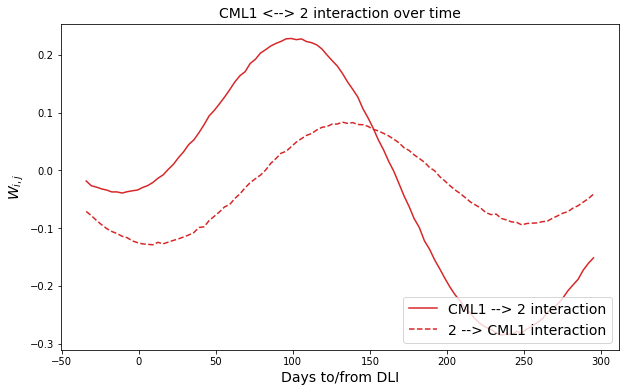

In [67]:
i = 7
j = 18
cluster_i = list(clusters_of_interest.keys())[i]
cluster_j = list(clusters_of_interest.keys())[j]

plt.figure(figsize=(10, 6))
plt.plot(predict_timepoints.squeeze(),
         W[:, i, j],
         linestyle='-',
         color='tab:red',
         label='%s --> %s interaction' % (cluster_j, cluster_i))
plt.plot(predict_timepoints.squeeze(),
         W[:, j, i],
         linestyle='--',
         color='tab:red',
         label='%s --> %s interaction' % (cluster_i, cluster_j))

plt.legend(loc='lower right', fontsize=14)
plt.title('CML1 <--> 2 interaction over time', fontsize=14)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('Days to/from DLI', fontsize=14)
plt.savefig('../../figures/CML/W_CML1_and_2_over_time_NR.eps', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


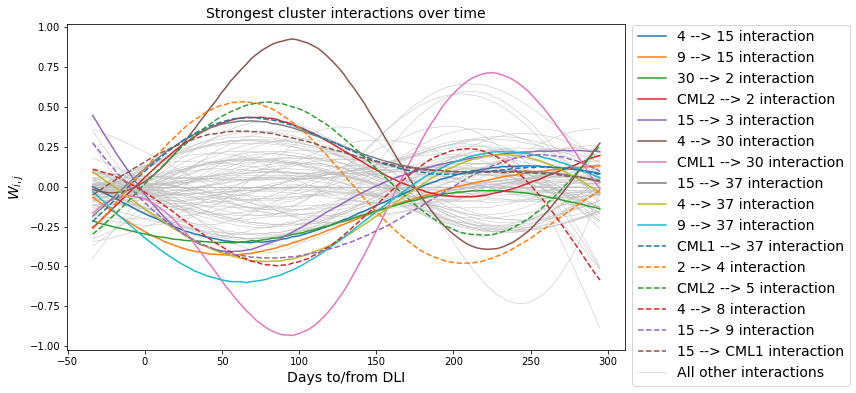

In [68]:
plt.figure(figsize=(10, 6))
linestyles = ['-', '--', ":"]
lines = 0
for i, cluster_i in enumerate(clusters_of_interest):
    for j, cluster_j in enumerate(clusters_of_interest):
        # a sustained strong interaction over the entire post-DLI time period
        sustained = np.abs(W_post_dli_avg_over_time[i, j]) > mean_abs_W_threshold
        # a transient strong interaction during the post-DLI time period
        transient = (np.abs(W_post_dli[:, i, j]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[i] > mu_sigma_threshold and
                     y_mu_over_sigma[j] > mu_sigma_threshold)
        show_line = (sustained or transient) and confident
        if show_line and i!= j:
            plt.plot(predict_timepoints.squeeze(), 
                     W[:, i, j],
                     linestyles[lines//10],
                     label='%s --> %s interaction' % (cluster_j, cluster_i))
            lines += 1
            
once = False
color = 'tab:gray'
color_with_alpha = list(colors2.to_rgb(color)) + [0.5]
color_without_alpha = colorAlpha_to_rgb([color_with_alpha], 0.5)
for i, cluster_i in enumerate(clusters_of_interest):
    for j, cluster_j in enumerate(clusters_of_interest):
        # a sustained strong interaction over the entire post-DLI time period
        sustained = np.abs(W_post_dli_avg_over_time[i, j]) > mean_abs_W_threshold
        # a transient strong interaction during the post-DLI time period
        transient = (np.abs(W_post_dli[:, i, j]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[i] > mu_sigma_threshold and
                     y_mu_over_sigma[j] > mu_sigma_threshold)
        show_line = (sustained or transient) and confident
        if not show_line and i != j:
            plt.plot(predict_timepoints.squeeze(), 
                     W[:, i, j],
                     color=color_without_alpha[0],
                     linewidth=0.5, zorder=-100,
                     label='All other interactions' if not once else '')
            once = True

plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left', fontsize=14)
plt.title('Strongest cluster interactions over time', fontsize=14)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('Days to/from DLI', fontsize=14)
plt.savefig('../../figures/CML/W_over_time_NR_all_interactions.eps', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


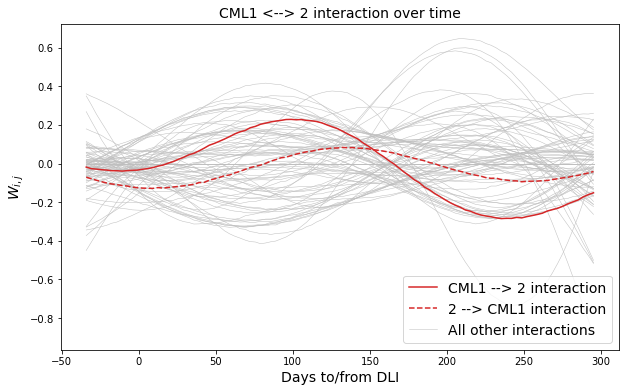

In [69]:
i = 7
j = 18
cluster_i = list(clusters_of_interest.keys())[i]
cluster_j = list(clusters_of_interest.keys())[j]

plt.figure(figsize=(10, 6))
plt.plot(predict_timepoints.squeeze(),
         W[:, i, j],
         linestyle='-',
         color='tab:red',
         label='%s --> %s interaction' % (cluster_j, cluster_i))
plt.plot(predict_timepoints.squeeze(),
         W[:, j, i],
         linestyle='--',
         color='tab:red',
         label='%s --> %s interaction' % (cluster_i, cluster_j))
            
once = False
color = 'tab:gray'
color_with_alpha = list(colors2.to_rgb(color)) + [0.5]
color_without_alpha = colorAlpha_to_rgb([color_with_alpha], 0.5)
for i, cluster_i in enumerate(clusters_of_interest):
    for j, cluster_j in enumerate(clusters_of_interest):
        # a sustained strong interaction over the entire post-DLI time period
        sustained = np.abs(W_post_dli_avg_over_time[i, j]) > mean_abs_W_threshold
        # a transient strong interaction during the post-DLI time period
        transient = (np.abs(W_post_dli[:, i, j]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[i] > mu_sigma_threshold and
                     y_mu_over_sigma[j] > mu_sigma_threshold)
        show_line = (sustained or transient) and confident
        if not show_line and i != j:
            plt.plot(predict_timepoints.squeeze(), 
                     W[:, i, j],
                     color=color_without_alpha[0],
                     linewidth=0.5, zorder=-100,
                     label='All other interactions' if not once else '')
            once = True

plt.legend(loc='lower right', fontsize=14)
plt.title('CML1 <--> 2 interaction over time', fontsize=14)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('Days to/from DLI', fontsize=14)
plt.savefig('../../figures/CML/W_CML1_and_2_over_time_NR_all_interactions.eps', bbox_inches='tight')

In [70]:
W_pre_dli_avg_edge_list = []

for row, target_cluster in enumerate(clusters_of_interest.keys()):
    for col, source_cluster in enumerate(clusters_of_interest.keys()):
        sustained = np.abs(W_post_dli_avg_over_time[row, col]) > mean_abs_W_threshold
        transient = (np.abs(W_post_dli[:, row, col]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[row] > mu_sigma_threshold and
                     y_mu_over_sigma[col] > mu_sigma_threshold)
        show_edge = (sustained or transient) and confident
        W_pre_dli_avg_edge_list.append({
            'Source cluster': source_cluster,
            'Target cluster': target_cluster,
            'Interaction weight': W_pre_dli_avg_over_time[row, col],
            'abs(Interaction weight)': np.abs(W_pre_dli_avg_over_time[row, col]) * show_edge,
            'sign(Interaction weight)': np.sign(W_pre_dli_avg_over_time[row, col])
        })

W_pre_dli_avg_edge_list_df = pd.DataFrame(W_pre_dli_avg_edge_list)

W_avg_edge_list_df = W_pre_dli_avg_edge_list_df
W_avg_edge_list_df.columns = ['source', 'target', 'Interaction weight', 
                              'abs(Interaction weight)', 'sign(Interaction weight)']
W_avg_edge_list_df[['source', 'target']] = W_avg_edge_list_df[['source', 'target']].astype(str)
W_avg_edge_list_df = W_avg_edge_list_df[W_avg_edge_list_df['source'] != W_avg_edge_list_df['target']]
W_avg_edge_list_df.head()

,source,target,Interaction weight,abs(Interaction weight),sign(Interaction weight)
1,1,0,0.002766,0.0,1.0
2,10,0,0.000000,0.0,0.0
3,11,0,0.000000,0.0,0.0
4,12,0,0.000000,0.0,0.0
5,15,0,-0.027973,0.0,-1.0


In [71]:
# y_preds = y_samples_predict.mean(axis=0).numpy()
y_preds_pre_dli = y_preds[X_100_days_pre_dli_index:X_post_dli_index]
y_preds_avg_pre_dli = y_preds_pre_dli.mean(axis=0)
y_preds_avg_pre_dli = [unscale(y, i) for i, y in enumerate(y_preds_avg_pre_dli)]
y_preds_avg_pre_dli_df = pd.DataFrame(y_preds_avg_pre_dli,
                                      index=clusters_of_interest, 
                                      columns=['Inferred cluster proportion'])

y_preds_avg_df = y_preds_avg_pre_dli_df.reset_index()
y_preds_avg_df.columns = ['id', 'Inferred cluster proportion']
y_preds_avg_df['id'] = y_preds_avg_df['id'].astype(str)
y_preds_avg_df

,id,Inferred cluster proportion
0,0,0.055054
1,1,0.037339
2,10,0.079729
3,11,0.046086
4,12,0.051906
5,15,0.044828
6,16,0.046336
7,2,0.056655
8,22,0.013511
9,25,0.016111


In [72]:
# Reduce clutter by removing nodes without edges
not_connected_cluster_ids = []
for cluster in clusters_of_interest:
    sum_abs_interaction_weights = (
        W_avg_edge_list_df.loc[(W_avg_edge_list_df['source'] == str(cluster)) | 
                               (W_avg_edge_list_df['target'] == str(cluster)), 
                               'abs(Interaction weight)'].sum()
    )
    if sum_abs_interaction_weights == 0: 
        not_connected_cluster_ids.append(str(cluster))

        
# Remove nodes with less than 1% cluster proportion
clusters_with_low_prop = y_preds_avg_df.loc[y_preds_avg_df['Inferred cluster proportion'] < 0.00, 'id']
clusters_with_low_prop = []

clusters_to_remove = not_connected_cluster_ids + list(clusters_with_low_prop)
W_avg_edge_list_df = W_avg_edge_list_df[~(W_avg_edge_list_df['source'].isin(clusters_to_remove)) & 
                                        ~(W_avg_edge_list_df['target'].isin(clusters_to_remove))]
y_preds_avg_df = y_preds_avg_df[~(y_preds_avg_df['id'].isin(clusters_to_remove))]

In [73]:
# Add clusters from R interaction network diagram
clusters_to_add = {
    '0': 'T cell',
    '11': 'Erythroid',
    '12': 'Erythroid',
    '13': 'NK cell',
    '20': 'B cell',
    '24': 'Myeloid',
    '23': 'B cell'
}

proportions_pre_dli_df = sample_cluster_proportions_all_df[sample_cluster_proportions_all_df['days_to_DLI'] < 0]
proportions_pre_dli_df = proportions_pre_dli_df[clusters_to_add].mean().reset_index()
proportions_pre_dli_df.columns = ['id', 'Inferred cluster proportion']
y_preds_avg_df = pd.concat([y_preds_avg_df, proportions_pre_dli_df])
y_preds_avg_df = y_preds_avg_df.sort_values('id').reset_index(drop=True)

# Add a fake 0 interactions so that cluster shows up in network diagram
for cluster in clusters_to_add:
    W_avg_edge_list_df = W_avg_edge_list_df.append({
        'source': cluster, 
        'target': '0', 
        'Interaction weight': 0,
        'abs(Interaction weight)': 0,
        'sign(Interaction weight)': 1
    }, ignore_index=True)
    W_avg_edge_list_df = W_avg_edge_list_df.append({
        'source': cluster, 
        'target': '5', 
        'Interaction weight': 0,
        'abs(Interaction weight)': 0,
        'sign(Interaction weight)': 1
    }, ignore_index=True)

/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_16212/1223375306.py:13: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  proportions_pre_dli_df = proportions_pre_dli_df[clusters_to_add].mean().reset_index()
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_16212/1223375306.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_avg_edge_list_df = W_avg_edge_list_df.append({
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_16212/1223375306.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_avg_edge_list_df = W_avg_edge_list_df.append({
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_16212/1223375306.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

In [74]:
colors_hex = {
    'T cell': '#CBE0EE',
    'B cell': '#F9E0F2',
    'Myeloid': '#F8CECD',
    'AML': '#E1E1E1',
    'CML': '#E1E1E1',
    'HSC': '#F8EBCB',
    'NK cell': '#E7DDF0',
    'Erythroid': '#FDE5CF'
}

clusters_to_colors_hex = [
    colors_hex[clusters_of_interest[cluster]] if cluster in clusters_of_interest
    else colors_hex[clusters_to_add[cluster]]
    for cluster in y_preds_avg_df['id']
]

# clusters_to_colors_hex = ['#CBE0EE' for cluster in y_preds_avg_df['id']]

Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
This file already exists. A Cytoscape popup will be generated to confirm overwrite.
This file already exists. A Cytoscape popup will be generated to confirm overwrite.


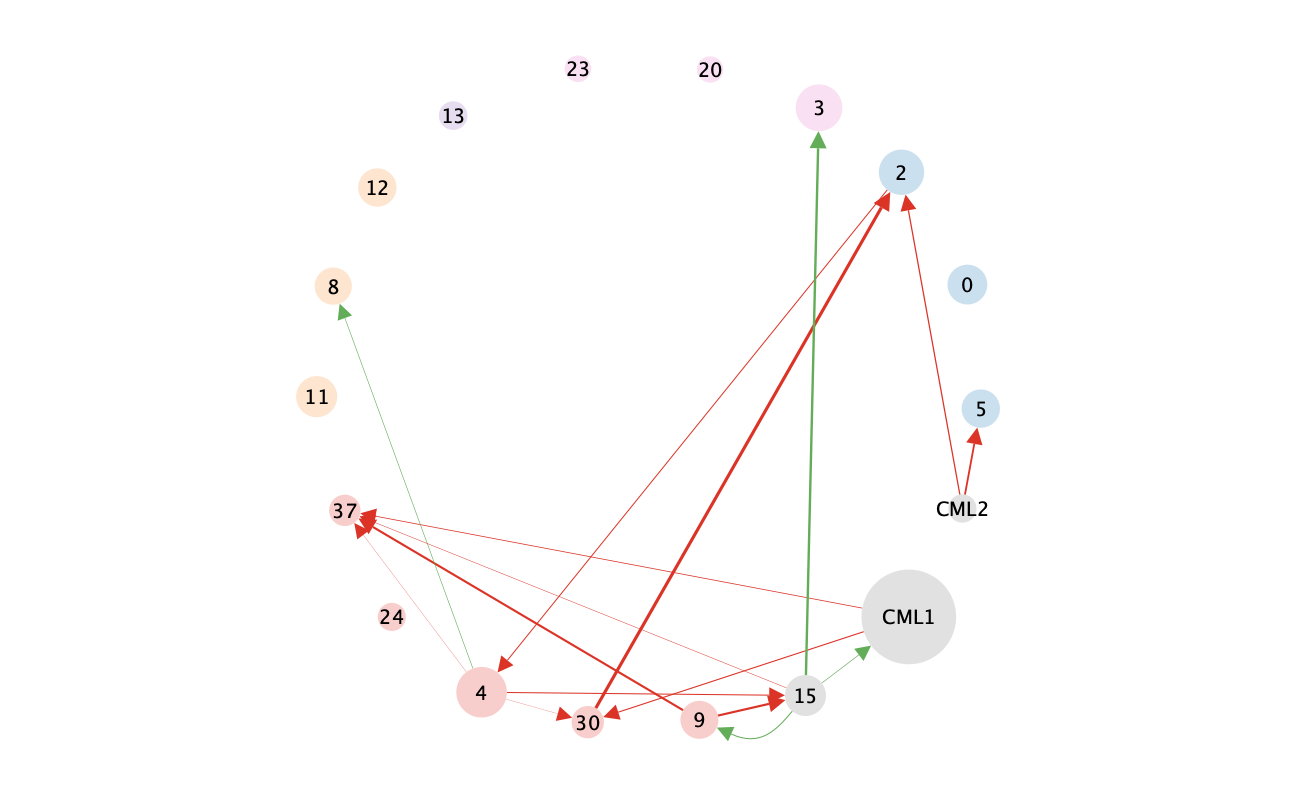

In [75]:
p4c.create_network_from_data_frames(nodes=y_preds_avg_df, 
                                    edges=W_avg_edge_list_df, 
                                    title="AML Non-responders Pre DLI", 
                                    collection="AML Non-responders Pre DLI")

# Default styles
p4c.layout_network('circular')
p4c.layout_copycat(source_network='AML Responders Pre DLI', 
                   target_network='AML Non-responders Pre DLI')
p4c.set_node_shape_default('ELLIPSE')
p4c.set_node_width_default(20)
p4c.set_node_height_default(20)
p4c.set_node_font_size_default(8)
p4c.set_edge_target_arrow_shape_default('DELTA_SHORT_1')

# Map style properties to node/edge attributes
p4c.set_node_color_mapping(table_column='shared name', 
                           table_column_values=list(y_preds_avg_df['id']), 
                           colors=clusters_to_colors_hex, 
                           mapping_type='d')
p4c.set_node_size_mapping(table_column='SUID',
                          table_column_values=list(p4c.get_table_columns()['SUID']),
                          sizes=list(p4c.get_table_columns()['Inferred cluster proportion'] * 150 + 10))
p4c.set_edge_color_mapping(table_column='sign(Interaction weight)',
                           table_column_values=[-1.0, 1.0],
                           colors=['#DB3427', '#63AD58'])
p4c.set_edge_target_arrow_color_mapping(table_column='sign(Interaction weight)',
                                        table_column_values=[-1.0, 1.0],
                                        colors=['#DB3427', '#63AD58'])
p4c.set_edge_line_width_mapping(table_column='abs(Interaction weight)', 
                                table_column_values=[W_avg_edge_list_df['abs(Interaction weight)'].min(), 
                                                     W_avg_edge_list_df['abs(Interaction weight)'].max()],
                                widths=[W_avg_edge_list_df['abs(Interaction weight)'].min() * 5, 
                                        W_avg_edge_list_df['abs(Interaction weight)'].max() * 5], 
                                mapping_type='c')
edges_to_hide = [f'{row.source} (interacts with) {row.target}' 
                 for i, row in W_avg_edge_list_df.iterrows()
                 if row['abs(Interaction weight)'] == 0]
p4c.hide_edges(edges_to_hide)

p4c.set_network_center_bypass(0, 0)
p4c.set_network_zoom_bypass(1.5)
p4c.export_image(f'../../figures/CML/interaction_network_NR_pre_avg.svg', type='SVG')
p4c.export_image(f'../../figures/CML/interaction_network_NR_pre_avg.png', type='PNG')
p4c.notebook_export_show_image()

In [76]:
W_post_dli_avg_edge_list = []

for row, target_cluster in enumerate(clusters_of_interest.keys()):
    for col, source_cluster in enumerate(clusters_of_interest.keys()):
        sustained = np.abs(W_post_dli_avg_over_time[row, col]) > mean_abs_W_threshold
        transient = (np.abs(W_post_dli[:, row, col]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[row] > mu_sigma_threshold and
                     y_mu_over_sigma[col] > mu_sigma_threshold)
        show_edge = (sustained or transient) and confident
        W_post_dli_avg_edge_list.append({
            'Source cluster': source_cluster,
            'Target cluster': target_cluster,
            'Interaction weight': W_post_dli_avg_over_time[row, col],
            'abs(Interaction weight)': np.abs(W_post_dli_avg_over_time[row, col]) * show_edge,
            'sign(Interaction weight)': np.sign(W_post_dli_avg_over_time[row, col])
        })
        
W_post_dli_avg_edge_list_df = pd.DataFrame(W_post_dli_avg_edge_list)

W_avg_edge_list_df = W_post_dli_avg_edge_list_df
W_avg_edge_list_df.columns = ['source', 'target', 'Interaction weight', 
                              'abs(Interaction weight)', 'sign(Interaction weight)']
W_avg_edge_list_df[['source', 'target']] = W_avg_edge_list_df[['source', 'target']].astype(str)
W_avg_edge_list_df = W_avg_edge_list_df[W_avg_edge_list_df['source'] != W_avg_edge_list_df['target']]
W_avg_edge_list_df.head()

,source,target,Interaction weight,abs(Interaction weight),sign(Interaction weight)
1,1,0,-0.147001,0.0,-1.0
2,10,0,0.000000,0.0,0.0
3,11,0,0.000000,0.0,0.0
4,12,0,0.000000,0.0,0.0
5,15,0,0.135815,0.0,1.0


In [77]:
# y_preds = y_samples_predict.mean(axis=0).numpy()
y_preds_post_dli = y_preds[X_post_dli_index:X_100_days_post_dli_index]
y_preds_avg_post_dli = y_preds_post_dli.mean(axis=0)
y_preds_avg_post_dli = [unscale(y, i) for i, y in enumerate(y_preds_avg_post_dli)]
y_preds_avg_post_dli_df = pd.DataFrame(y_preds_avg_post_dli,
                                      index=clusters_of_interest, 
                                      columns=['Inferred cluster proportion'])

y_preds_avg_df = y_preds_avg_post_dli_df.reset_index()
y_preds_avg_df.columns = ['id', 'Inferred cluster proportion']
y_preds_avg_df['id'] = y_preds_avg_df['id'].astype(str)
y_preds_avg_df

,id,Inferred cluster proportion
0,0,0.059135
1,1,0.041919
2,10,0.079730
3,11,0.046086
4,12,0.051906
5,15,0.037305
6,16,0.046336
7,2,0.044297
8,22,0.010058
9,25,0.034512


In [78]:
# Reduce clutter by removing nodes without edges
not_connected_cluster_ids = []
for cluster in clusters_of_interest:
    sum_abs_interaction_weights = (
        W_avg_edge_list_df.loc[(W_avg_edge_list_df['source'] == str(cluster)) | 
                               (W_avg_edge_list_df['target'] == str(cluster)), 
                               'abs(Interaction weight)'].sum()
    )
    if sum_abs_interaction_weights == 0: 
        not_connected_cluster_ids.append(str(cluster))

        
# Remove nodes with less than 1% cluster proportion
clusters_with_low_prop = y_preds_avg_df.loc[y_preds_avg_df['Inferred cluster proportion'] < 0.00, 'id']
clusters_with_low_prop = []

clusters_to_remove = not_connected_cluster_ids + list(clusters_with_low_prop)
W_avg_edge_list_df = W_avg_edge_list_df[~(W_avg_edge_list_df['source'].isin(clusters_to_remove)) & 
                                        ~(W_avg_edge_list_df['target'].isin(clusters_to_remove))]
y_preds_avg_df = y_preds_avg_df[~(y_preds_avg_df['id'].isin(clusters_to_remove))]

In [79]:
# Add clusters from R interaction network diagram
clusters_to_add = {
    '0': 'T cell',
    '11': 'Erythroid',
    '12': 'Erythroid',
    '13': 'NK cell',
    '20': 'B cell',
    '24': 'Myeloid',
    '23': 'B cell'
}

proportions_post_dli_df = sample_cluster_proportions_all_df[sample_cluster_proportions_all_df['days_to_DLI'] >= 0]
proportions_post_dli_df = proportions_post_dli_df[clusters_to_add].mean().reset_index()
proportions_post_dli_df.columns = ['id', 'Inferred cluster proportion']
y_preds_avg_df = pd.concat([y_preds_avg_df, proportions_post_dli_df])
y_preds_avg_df = y_preds_avg_df.sort_values('id').reset_index(drop=True)

# Add a fake 0 interactions so that cluster shows up in network diagram
for cluster in clusters_to_add:
    W_avg_edge_list_df = W_avg_edge_list_df.append({
        'source': cluster, 
        'target': '0', 
        'Interaction weight': 0,
        'abs(Interaction weight)': 0,
        'sign(Interaction weight)': 1
    }, ignore_index=True)
    W_avg_edge_list_df = W_avg_edge_list_df.append({
        'source': cluster, 
        'target': '5', 
        'Interaction weight': 0,
        'abs(Interaction weight)': 0,
        'sign(Interaction weight)': 1
    }, ignore_index=True)

/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_16212/1574136944.py:13: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  proportions_post_dli_df = proportions_post_dli_df[clusters_to_add].mean().reset_index()
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_16212/1574136944.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_avg_edge_list_df = W_avg_edge_list_df.append({
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_16212/1574136944.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_avg_edge_list_df = W_avg_edge_list_df.append({
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_16212/1574136944.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future

Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
This file already exists. A Cytoscape popup will be generated to confirm overwrite.
This file already exists. A Cytoscape popup will be generated to confirm overwrite.


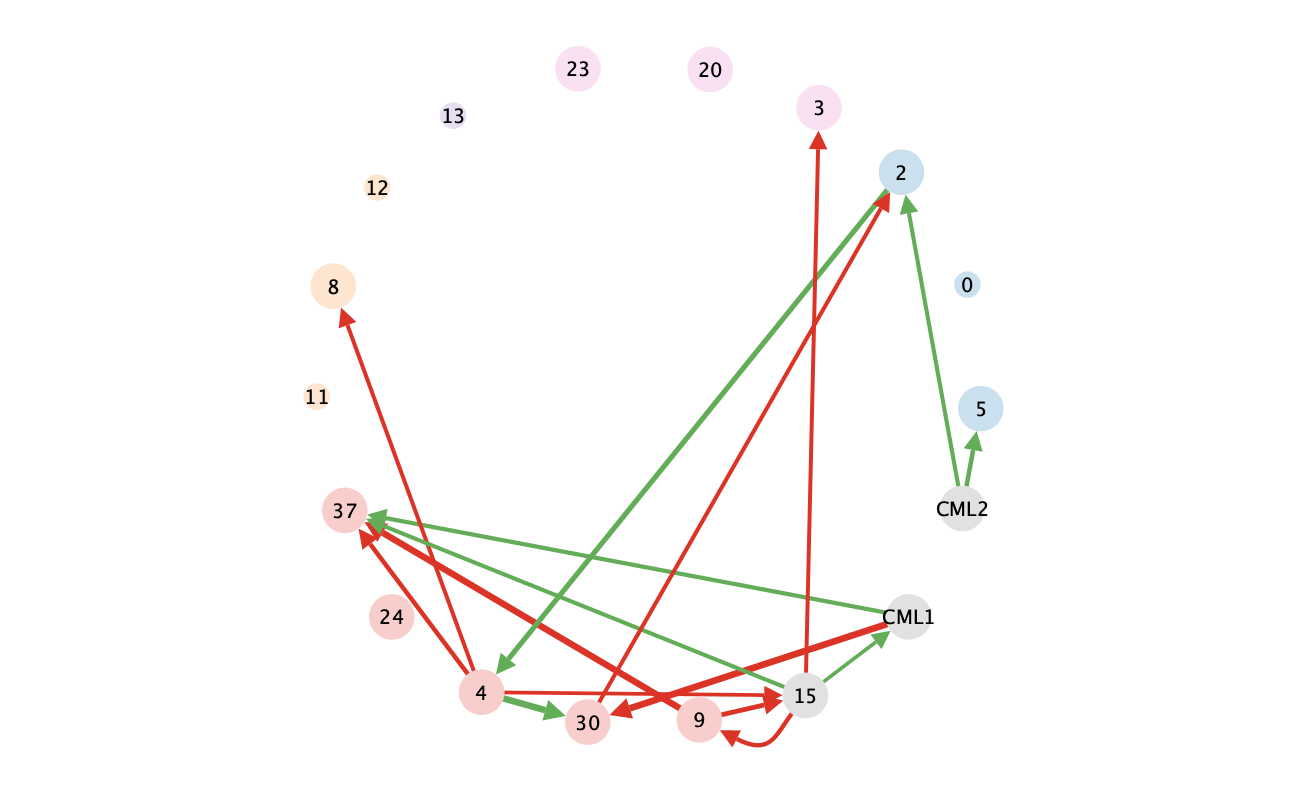

In [80]:
p4c.create_network_from_data_frames(nodes=y_preds_avg_df, 
                                    edges=W_avg_edge_list_df, 
                                    title="AML Non-responders Post DLI", 
                                    collection="AML Non-responders Post DLI")

# Default styles
p4c.layout_copycat(source_network='AML Responders Pre DLI', 
                   target_network='AML Non-responders Post DLI')
p4c.set_node_shape_default('ELLIPSE')
p4c.set_node_width_default(20)
p4c.set_node_height_default(20)
p4c.set_node_font_size_default(8)
p4c.set_edge_target_arrow_shape_default('DELTA_SHORT_1')

# Map style properties to node/edge attributes
p4c.set_node_color_mapping(table_column='shared name', 
                           table_column_values=list(y_preds_avg_df['id']), 
                           colors=clusters_to_colors_hex, 
                           mapping_type='d')
p4c.set_node_size_mapping(table_column='SUID',
                          table_column_values=list(p4c.get_table_columns()['SUID']),
                          sizes=list(p4c.get_table_columns()['Inferred cluster proportion'] * 150 + 10))
p4c.set_edge_color_mapping(table_column='sign(Interaction weight)',
                           table_column_values=[-1.0, 1.0],
                           colors=['#DB3427', '#63AD58'])
p4c.set_edge_target_arrow_color_mapping(table_column='sign(Interaction weight)',
                                        table_column_values=[-1.0, 1.0],
                                        colors=['#DB3427', '#63AD58'])
p4c.set_edge_line_width_mapping(table_column='abs(Interaction weight)', 
                                table_column_values=[W_avg_edge_list_df['abs(Interaction weight)'].min(), 
                                                     W_avg_edge_list_df['abs(Interaction weight)'].max()],
                                widths=[W_avg_edge_list_df['abs(Interaction weight)'].min() * 5, 
                                        W_avg_edge_list_df['abs(Interaction weight)'].max() * 5], 
                                mapping_type='c')
edges_to_hide = [f'{row.source} (interacts with) {row.target}' 
                 for i, row in W_avg_edge_list_df.iterrows()
                 if row['abs(Interaction weight)'] == 0]
p4c.hide_edges(edges_to_hide)

p4c.set_network_center_bypass(0, 0)
p4c.set_network_zoom_bypass(1.5)
p4c.export_image(f'../../figures/CML/interaction_network_NR_post_avg.svg', type='SVG')
p4c.export_image(f'../../figures/CML/interaction_network_NR_post_avg.png', type='PNG')
p4c.notebook_export_show_image()